In [1]:
import spotchaos.syntheticSignals as sp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import tqdm
import pickle
import os
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit

### Gaussian noise

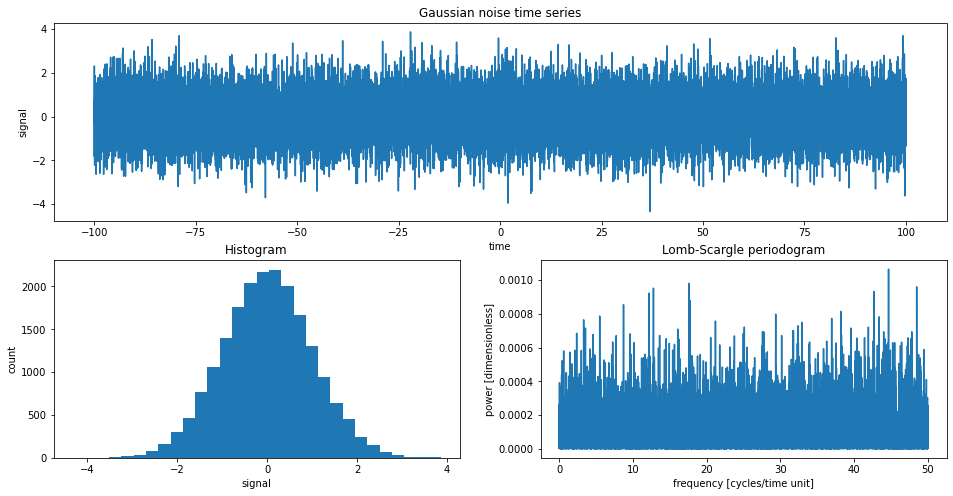

In [2]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise = np.random.normal(0.,1.,len(t))
sp.plotTimeSeries(t, gaussianNoise,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Gaussian noise")

### Multiperiodic signals

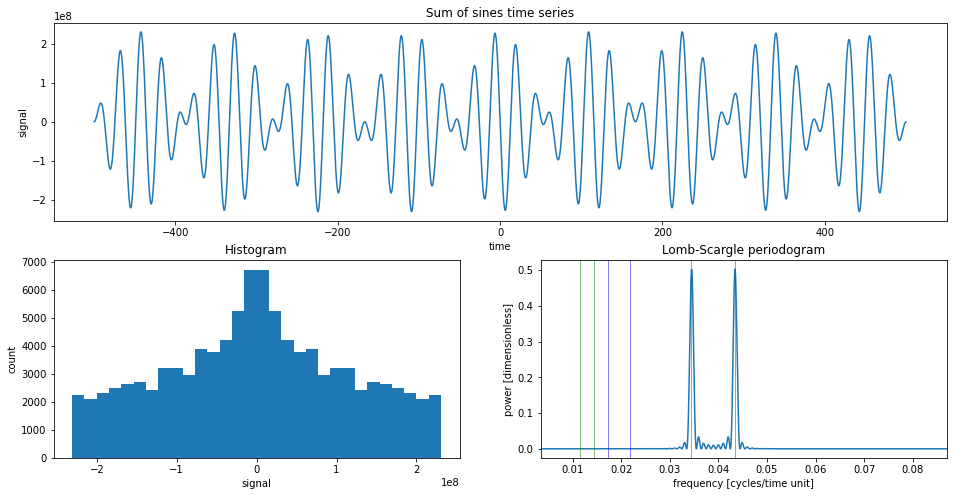

In [3]:
dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

v1 = 2*np.pi*(1./23.)
v2 = 2*np.pi*(1./29.)

trueFreqs = np.array((1./23.,1./29.))

simplePeriodic = (np.sin(t*v1) + np.sin(t*v2))
simplePeriodic = simplePeriodic/np.mean(simplePeriodic)
sp.plotTimeSeries(t, simplePeriodic,min_freq=(1./baseline),max_freq=(1./(2.*dt)), nq=10, spp=100, 
               LS_xlim = (0.1*np.min(trueFreqs),2*np.max(trueFreqs)), plot_harmonics=True, 
               true_freq=trueFreqs,title="Sum of sines")

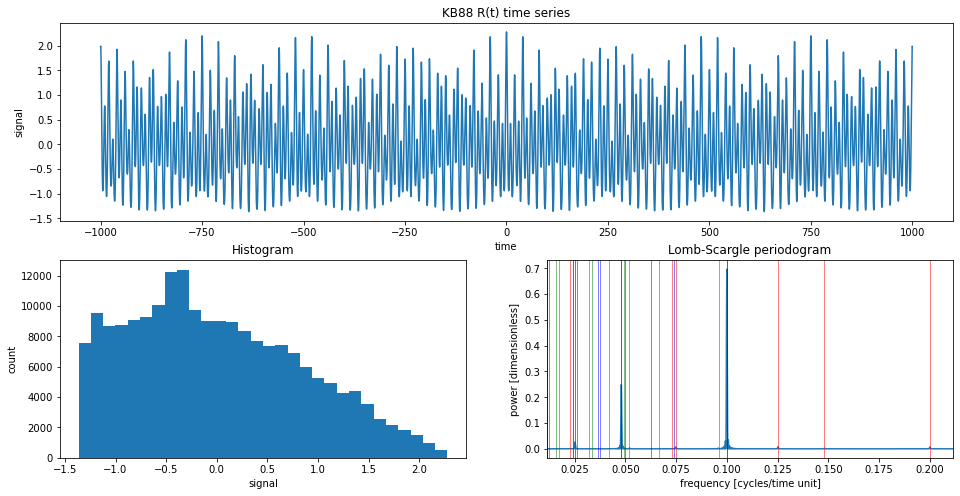

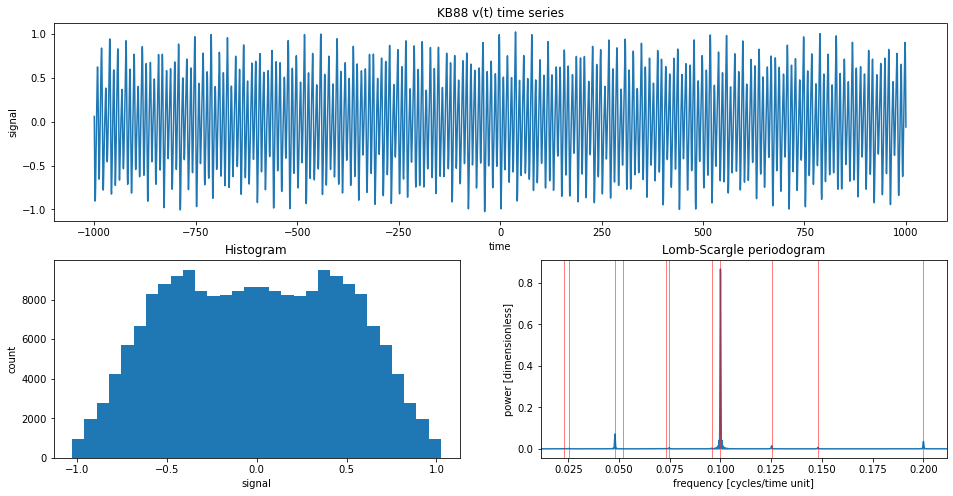

In [4]:
# multi-periodic signal from Kovacs & Buchler 1988
dt = 0.01
tmin = -1000.
tmax = 1000.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

multiPeriodic_r, multiPeriodic_v = sp.KB88(t)

trueFreqs = np.array((0.1, 0.048, 0.0252, 0.1+0.048, 0.1-0.048, 0.048+0.0252, 0.048-0.0252, 0.1+0.0252, 0.1-0.0252, 2*0.1, 2*0.048,))

sp.plotTimeSeries(t, multiPeriodic_r, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, plot_harmonics=True, title="KB88 R(t)")
sp.plotTimeSeries(t, multiPeriodic_v, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, title="KB88 v(t)")

### Rossler system 

In [5]:
fp1, fp2 = sp.Rossler_FPs(a=0.2,b=0.2,c=5.7)
print(fp1)
print(fp2)

[  5.6929738  -28.46486898  28.46486898]
[ 0.0070262  -0.03513102  0.03513102]


[ 3.45344022 -1.10983499  0.07186731]


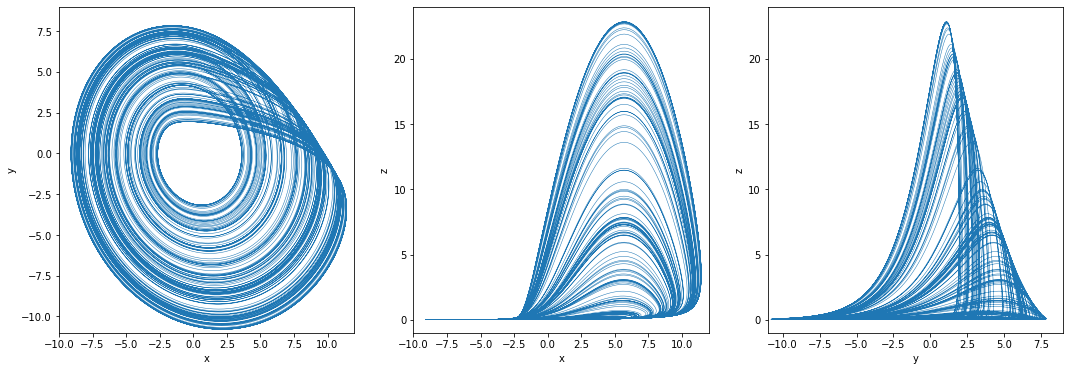

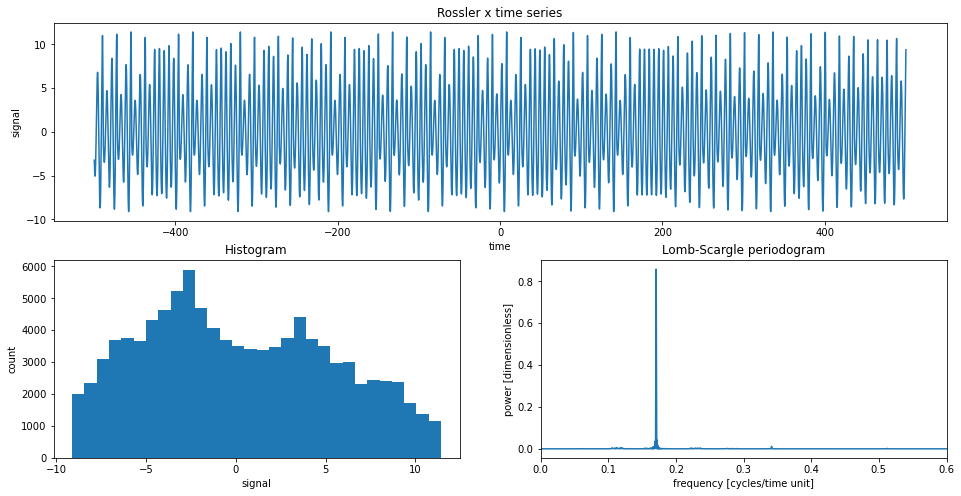

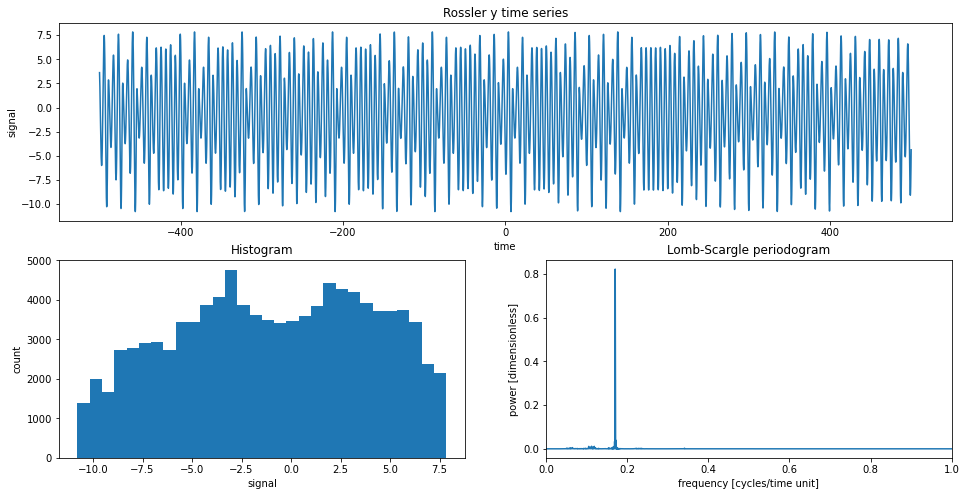

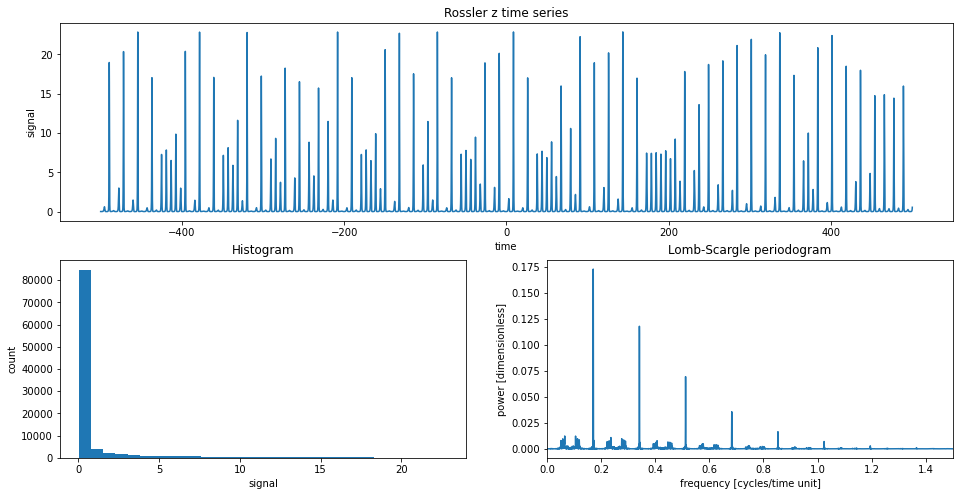

In [9]:
#r0 = np.array((0.1, -7, 0.1))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-3.19582017,  3.64416763, 0.02384456))

# fixed point experiment 
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 5.6929738
fp1_y = -28.46486898
fp1_z = 28.46486898
#r0 = np.array((fp1_x, fp1_y, fp1_z))

fp2_x = 0.0070262
fp2_y = -0.03513102
fp2_z = 0.03513102
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rossler = RK45(fun=sp.Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rossler_r = np.empty((Nsteps,3))
rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rossler.step()
    rossler_t[i] = rossler.t
    rossler_r[i] = rossler.y

print(rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rossler_r[:,0],rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-10,12)
axes[0].set_ylim(-11,9)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rossler_r[:,0],rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-10,12)
axes[1].set_ylim(-1,24)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rossler_r[:,1],rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-11,9)
axes[2].set_ylim(-1,24)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(rossler_t,rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,0.6),title="Rossler x")
sp.plotTimeSeries(rossler_t,rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.),title="Rossler y")
sp.plotTimeSeries(rossler_t,rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.5),title="Rossler z")

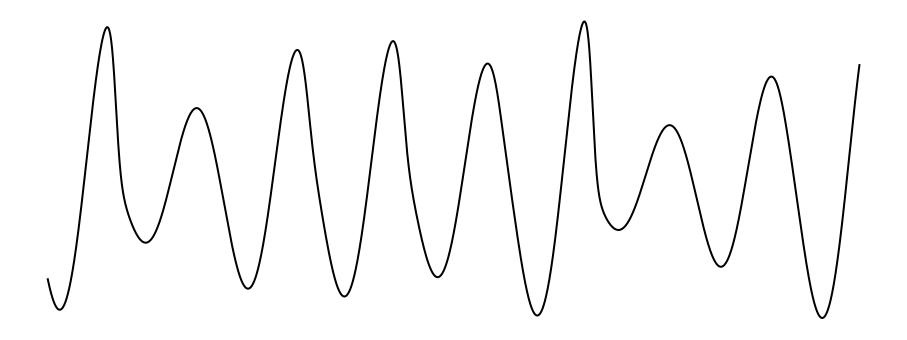

In [10]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(rossler_t[-15000:-10000],rossler_r[-15000:-10000,0],'k-',lw=2)
ax.axis("off")
plt.savefig("./rossler_x_forposter.pdf")


### Rotated Rossler system (inspired by Letellier & Aguirre 2002)

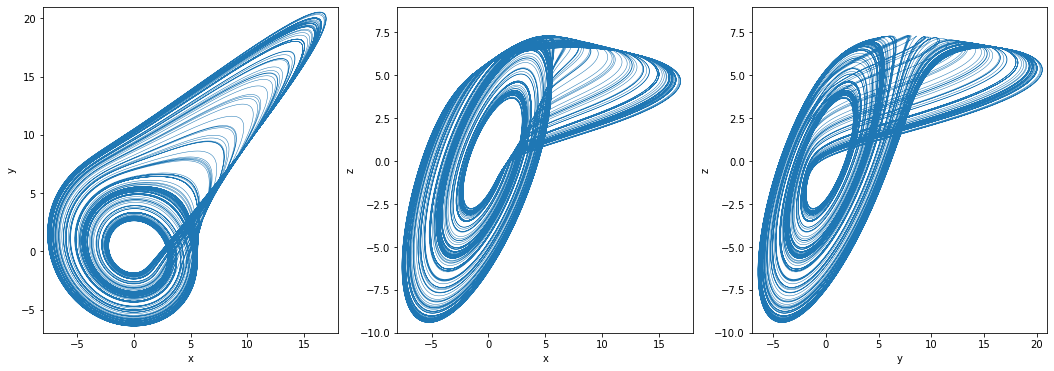

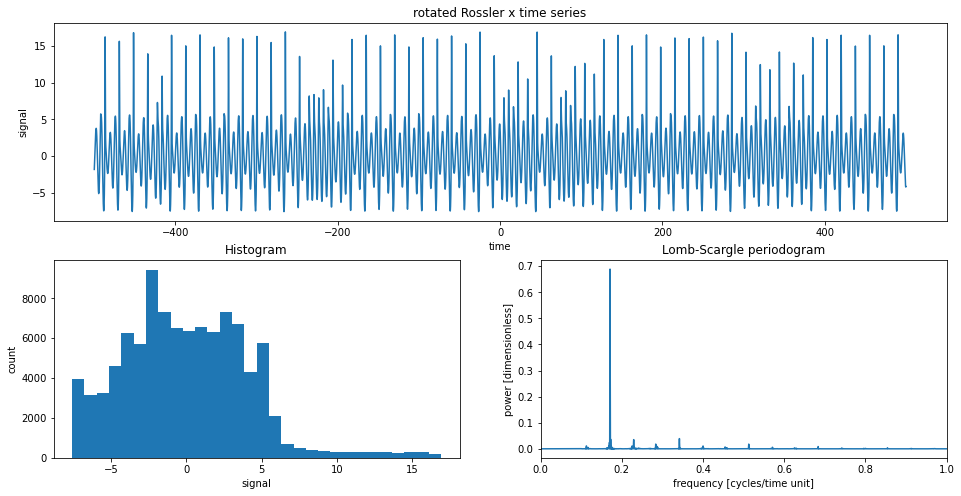

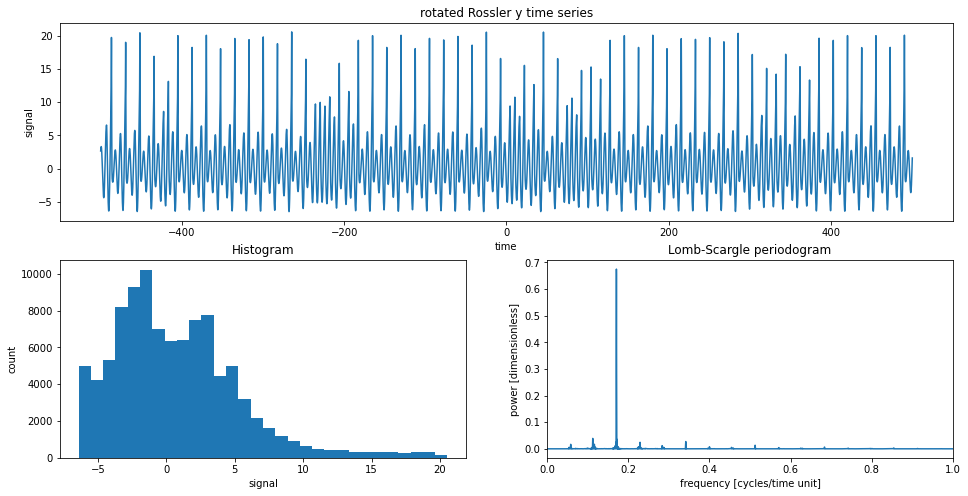

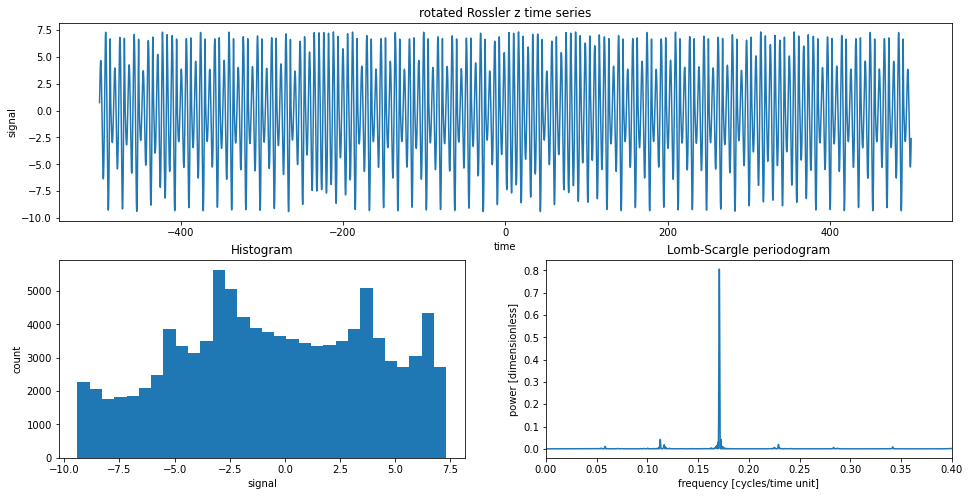

In [14]:
#r0 = (1./np.sqrt(2))*np.array((3.6+0.02, 0.02-3.2, -3.2+3.6))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-1.86683832,  2.65479799,  0.69061283))

# fixed point experiment
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 5.6929738
fp1_y = -28.46486898
fp1_z = 28.46486898
#r0 = (1./np.sqrt(2))*np.array((fp1_y + fp1_z, fp1_x+fp1_z, fp1_x+fp1_y))

fp2_x = 0.0070262
fp2_y = -0.03513102
fp2_z = 0.03513102
#r0 = (1./np.sqrt(2))*np.array((fp2_y + fp2_z, fp2_x+fp2_z, fp2_x+fp2_y))



dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rotated_rossler = RK45(fun=sp.rotated_Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rotated_rossler_r = np.empty((Nsteps,3))
rotated_rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rotated_rossler.step()
    rotated_rossler_t[i] = rotated_rossler.t
    rotated_rossler_r[i] = rotated_rossler.y
    #print(i, rotated_rossler_r[i])
#print(rotated_rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rotated_rossler_r[:,0],rotated_rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-8,18)
axes[0].set_ylim(-7,21)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rotated_rossler_r[:,0],rotated_rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-8,18)
axes[1].set_ylim(-10,9)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rotated_rossler_r[:,1],rotated_rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-7,21)
axes[2].set_ylim(-10,9)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="rotated Rossler x")
sp.plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="rotated Rossler y")
sp.plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,0.4),title="rotated Rossler z")

### Lorenz system

In [15]:
fp1, fp2 = sp.Lorenz_FPs(sigma=10., beta=8./3., rho=28.)
print(fp1)
print(fp2)

unstable
[ 8.48528137  8.48528137 27.        ]
[-8.48528137 -8.48528137 27.        ]


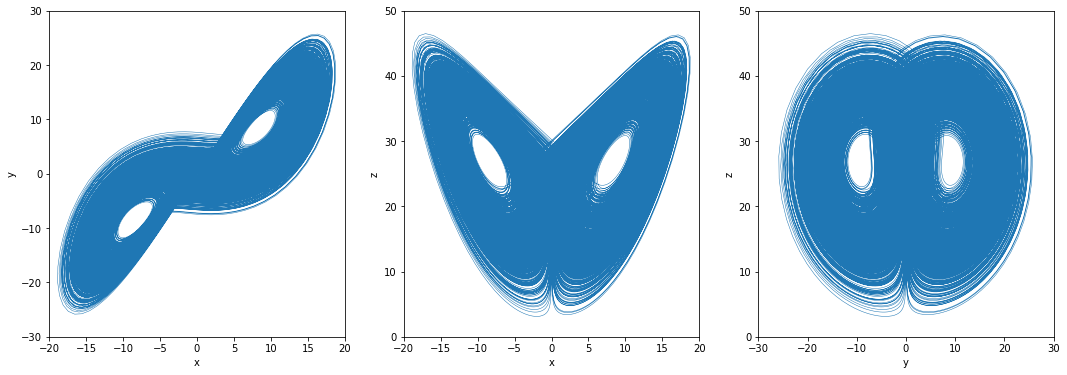

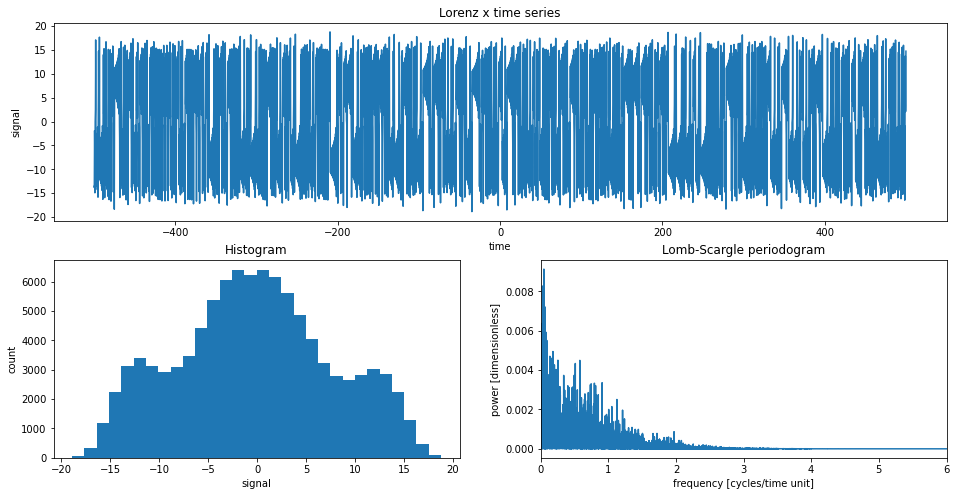

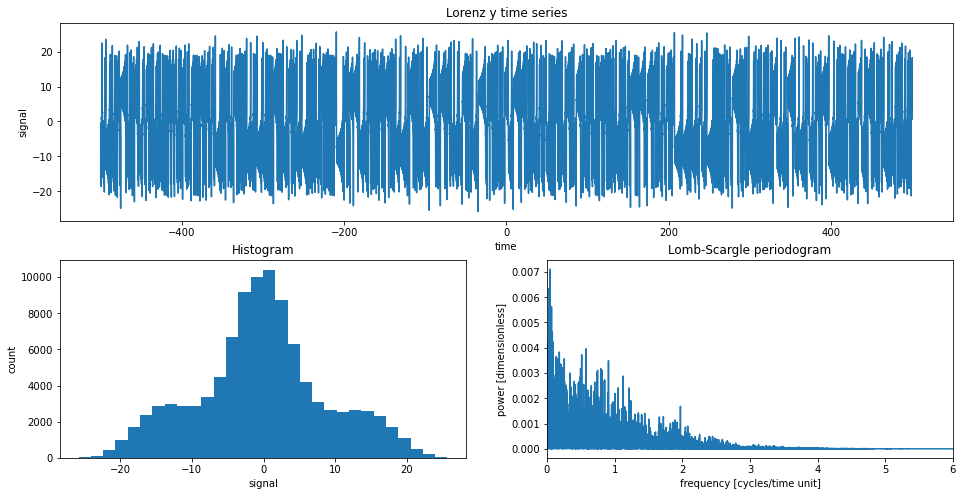

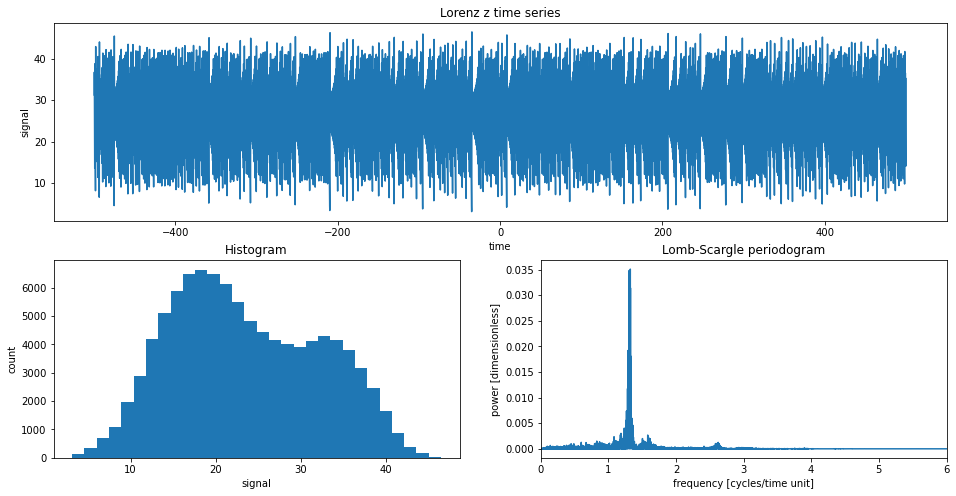

In [16]:
#r0 = np.array((1., 1., 1.))
# the above IC isn't yet on the attractor, has a brief transient; the below is chosen as the 5000th iteration of the above
# and seems to be safely on the attractor
r0 = np.array((-13.29390985, -16.32060497,  29.90864944))


#fixed point experiments
# because rho > 1, expect 2 fixed points (at the center of the lobes)
# points are both stable if rho < sigma * ((sigma + beta + 3)/(sigma - beta - 1))
# given the choice of parameters above, the RHS of that inequality is ~= 24.7
# so we expect the two FPs to be *unstable*.
fp1_x = 8.48528137
fp1_y = 8.48528137
fp1_z = 27.

fp2_x = -fp1_x
fp2_y = -fp1_y
fp2_z = fp1_z

#r0 = np.array((fp1_x, fp1_y, fp1_z))
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

lorenz_r = np.empty((Nsteps,3))
lorenz_t = np.empty((Nsteps))
for i in range(Nsteps):
    lorenz.step()
    lorenz_t[i] = lorenz.t
    lorenz_r[i] = lorenz.y


fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(lorenz_r[:,0],lorenz_r[:,1],lw=0.5)
axes[0].set_xlim(-20,20)
axes[0].set_ylim(-30,30)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(lorenz_r[:,0],lorenz_r[:,2],lw=0.5)
axes[1].set_xlim(-20,20)
axes[1].set_ylim(0,50)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(lorenz_r[:,1],lorenz_r[:,2],lw=0.5)
axes[2].set_xlim(-30,30)
axes[2].set_ylim(0,50)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(lorenz_t,lorenz_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz x")
sp.plotTimeSeries(lorenz_t,lorenz_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz y")
sp.plotTimeSeries(lorenz_t,lorenz_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz z")

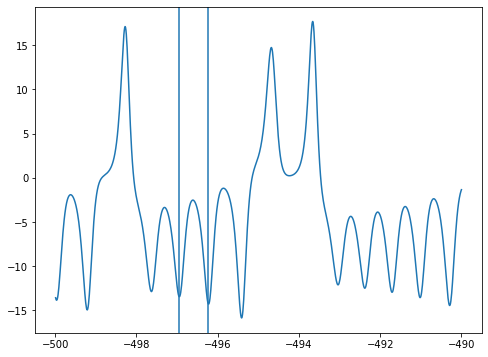

71.99999999999704


In [17]:
#sp.plotTimeSeries(lorenz_t[:1000],lorenz_r[:1000,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz x")
#sp.plotTimeSeries(lorenz_t[:5000],lorenz_r[:5000,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz x")
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(lorenz_t[:1000],lorenz_r[:1000,0])
ax.axvline(-496.95)
ax.axvline(-496.23)
plt.show()
#print(len(lorenz_r[:1000,0][lorenz_r[:1000,0] > 0.]))
#print(len(lorenz_r[:5000,0][lorenz_r[:5000,0] > 0.]))

print((-496.23+496.95)/0.01)

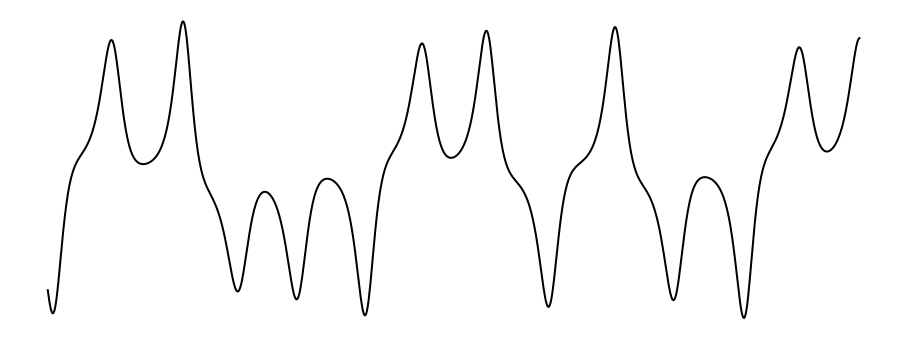

In [18]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(lorenz_t[-1000:],lorenz_r[-1000:,0],'k-',lw=2)
ax.axis("off")
plt.savefig("./lorenz_x_forposter.pdf")


## Number of data points 

In [13]:
print(np.shape(rossler_t))
print(np.shape(rossler_r))

(100000,)
(100000, 3)


In [14]:
print(np.shape(rotated_rossler_t))
print(np.shape(rotated_rossler_r))

(100000,)
(100000, 3)


In [15]:
print(np.shape(lorenz_t))
print(np.shape(lorenz_r))

(100000,)
(100000, 3)


# Choose time delay

### Fraser & Swinney 1986 (used 32,768 points for the Belousov-Zhabotinskii rxn; 1,048,576 points for the Rossler system)

### note: keep track of time taken per choice of delay time

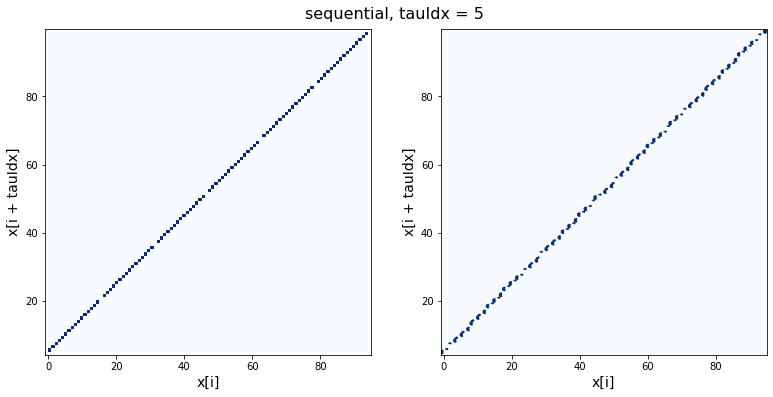

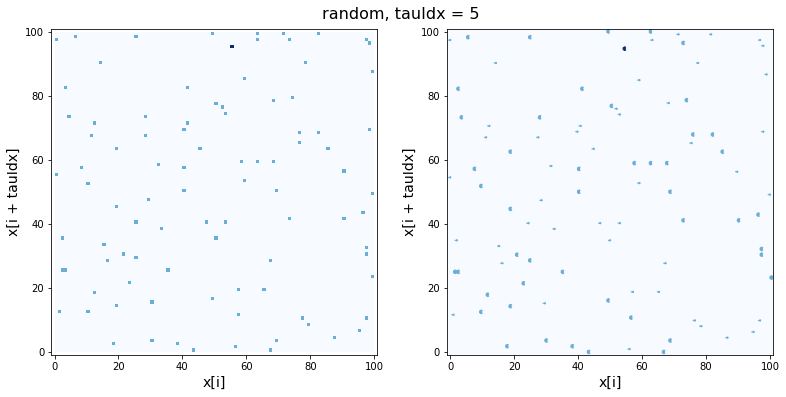

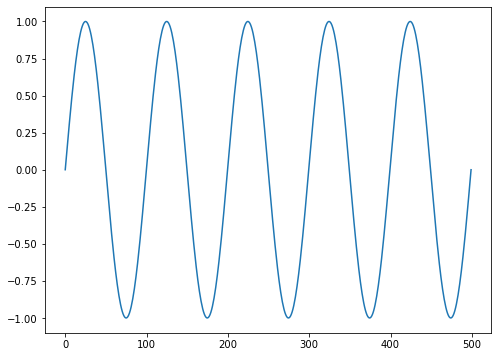

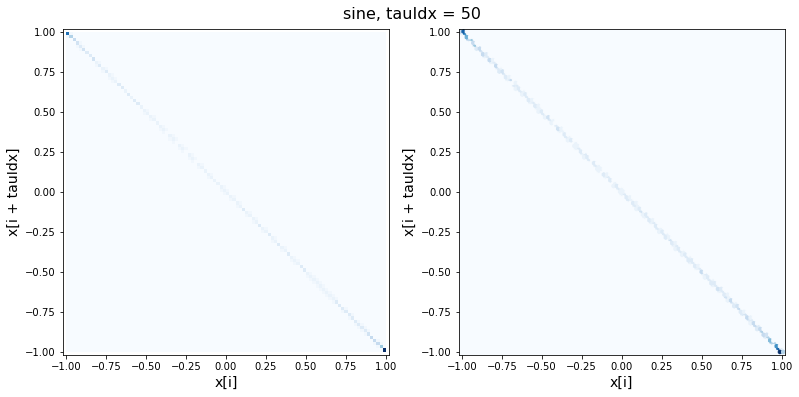

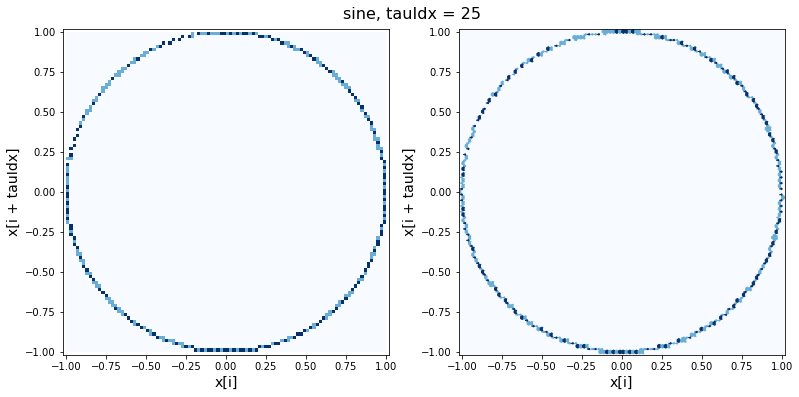

In [19]:
# test cases:
# sequential array
sp.bin2D(timeSeries=np.arange(100),tauIdx=5,plotTitle="sequential, tauIdx = 5")
# random array
sp.bin2D(timeSeries=np.random.randint(0,101,100),tauIdx=5,plotTitle="random, tauIdx = 5")
# correlated array
corr_arr = np.sin(np.linspace(0.,10.*np.pi,500))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(corr_arr)
plt.show()
sp.bin2D(timeSeries=corr_arr, tauIdx = 50, plotTitle="sine, tauIdx = 50") # non-optimal! 
sp.bin2D(timeSeries=corr_arr, tauIdx = 25, plotTitle="sine, tauIdx = 25") # optimal! 50*n = perfect linear correlation

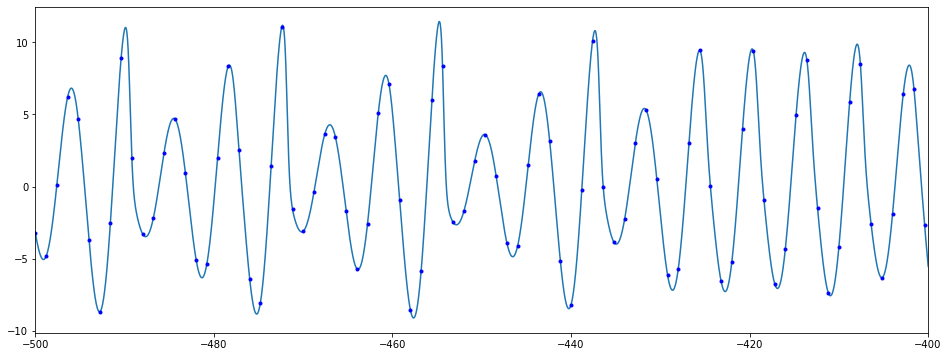

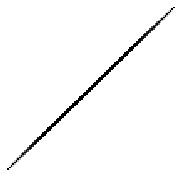

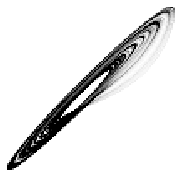

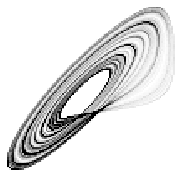

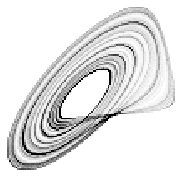

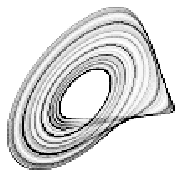

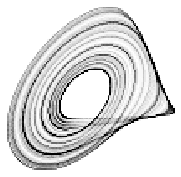

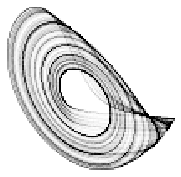

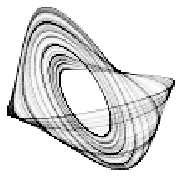

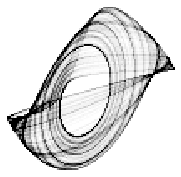

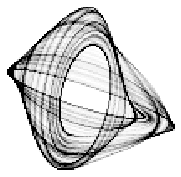

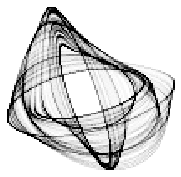

In [20]:
# rossler
testDelayIdxs = np.array((1,20,50,75,100,109,200,400,500,750,1000))
#testDelayIdxs = np.arange(1,201,10)
#testDelayIdxs = np.arange(110,130,10)
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(rossler_t,rossler_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation,
# not maximal! so the delay should not correspond to an inherent periodicity of the system.
delay = 120
ax.plot(rossler_t[::delay],rossler_r[::delay,0,],'b.')
ax.set_xlim(-500,-400)
plt.show()

vmaxs = np.array((120,70,60,60,50,50,50,50,50,40,40))
for i, t in enumerate(testDelayIdxs):
    #sp.bin2D(timeSeries=rossler_r[:,0], tauIdx = i, plotTitle="tauIdx = {0}".format(i))
    x = rossler_r[:,0][:-t]
    y = rossler_r[:,0][t:]
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    ax.hist2d(x,y,bins=(100,100),cmap="Greys",vmin=0,vmax=vmaxs[i])
    ax.axis("off")
    plt.savefig("./rossler_x_forposter_tauIdx={0}.pdf".format(t))
    #plt.show()
#this is SO COOL
# so just by eye it looks like the first minimum of the mutual information should fall around tau~120 for the Rossler x 
# time series.

In [15]:
MI = np.zeros((500))

start = time.time()
for i in range(500):
    MI[i] = sp.calc_MI(lorenz_r[:-(i+1),0], lorenz_r[(i+1):,0],Xbins=sp.optimal_Nbins(lorenz_r[:-(i+1),0]), Ybins = sp.optimal_Nbins(lorenz_r[(i+1):,0]))
end = time.time()
print((end - start)/500.)

0.01916825199127197


In [16]:
#expectation of first minimum, based on FS86
firstMin = ((193.3*(np.pi/100.)) * 0.23) * 100
print(firstMin)

139.67206778594863


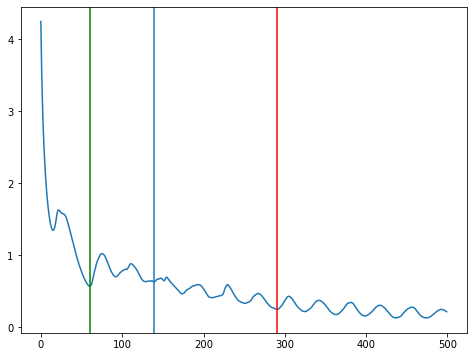

290


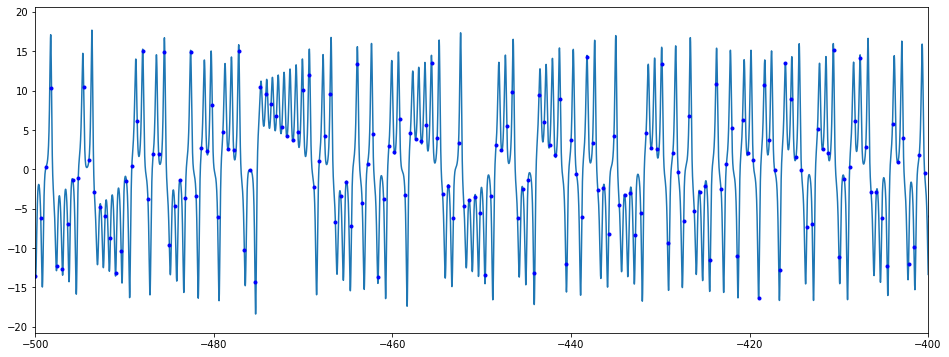

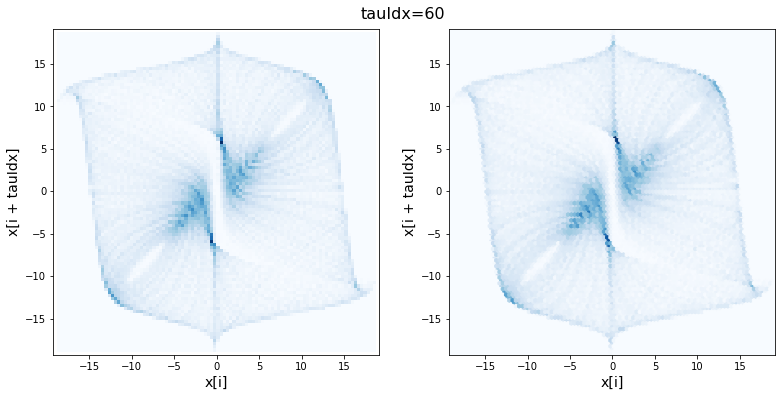

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(MI)
ax.axvline(firstMin)
ax.axvline(np.argmin(MI[0:300]),color='r')
ax.axvline(45+15,color='g')
plt.show()
print(np.argmin(MI[0:300]))

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(lorenz_t,lorenz_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation,
# not maximal! so the delay should not correspond to an inherent periodicity of the system.
delay = 60 #np.argmin(MI[0:300])
ax.plot(lorenz_t[::delay],lorenz_r[::delay,0,],'b.')
ax.set_xlim(-500,-400)
plt.show()
sp.bin2D(timeSeries=lorenz_r[:,0], tauIdx = 60, plotTitle="tauIdx=60")#plotTitle="tauIdx = {0}".format(np.argmin(MI[0:300])))

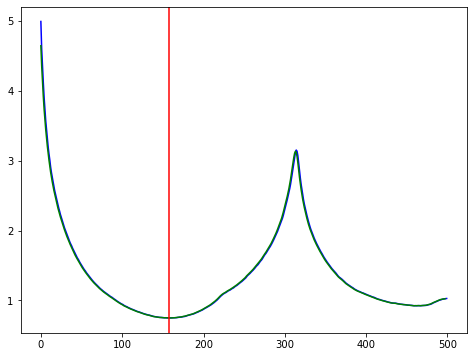

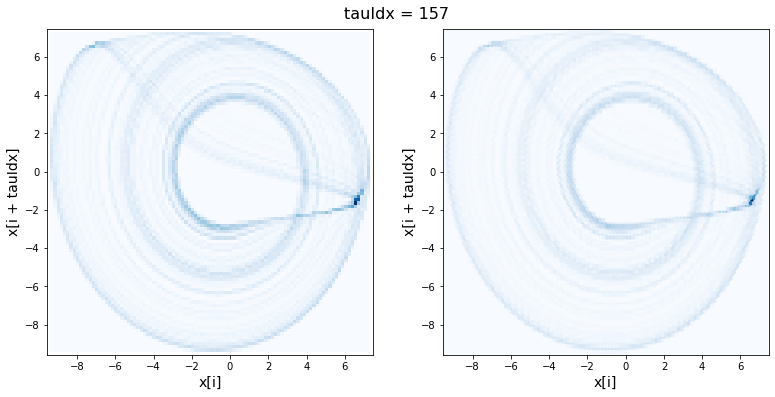

In [26]:
mutInfo, bestTau = sp.FS86(timeSeries = rotated_rossler_r[:,2], trialDelayIndices = np.arange(0,500), plot=True)

# Choose embedding dimension

### Cao 1997

### Rossler

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


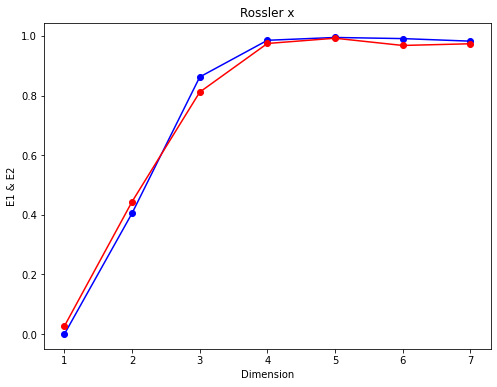

In [27]:
E1, E2 = sp.cao97(timeSeries = rossler_r[:5000,0], tau = 115, mMax = 8)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rossler x')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rossler_x.png")

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


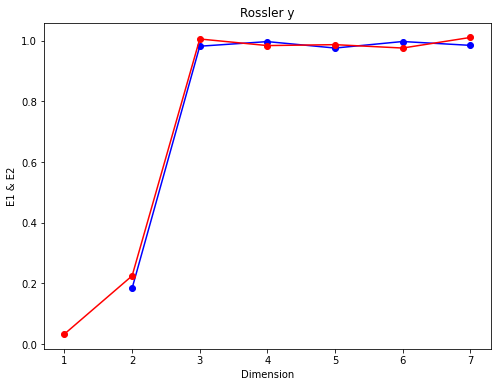

In [28]:
E1, E2 = sp.cao97(timeSeries = rossler_r[:5000,1], tau = 148, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rossler y')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rossler_y.png")

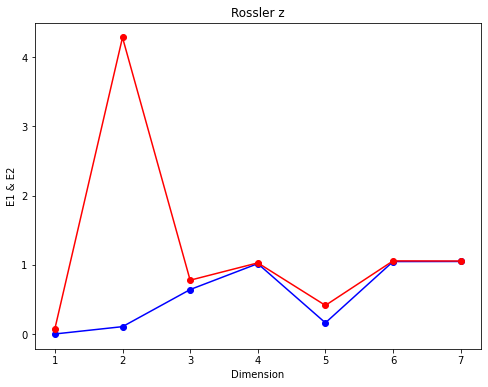

In [29]:
E1, E2 = sp.cao97(timeSeries = rossler_r[:5000,2], tau = 195, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rossler z')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rossler_z.png")

### Rotated Rossler

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


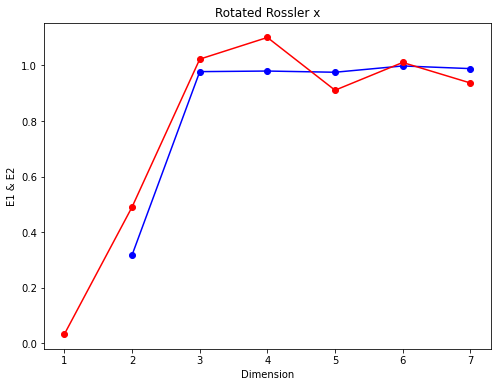

In [30]:
E1, E2 = sp.cao97(timeSeries = rotated_rossler_r[:5000,0], tau = 146, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rotated Rossler x')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rotated_rossler_x.png")

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


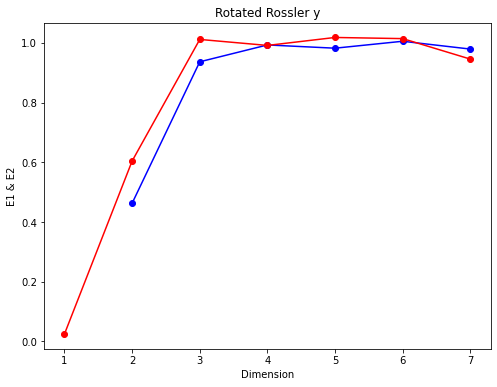

In [31]:
E1, E2 = sp.cao97(timeSeries = rotated_rossler_r[:5000,1], tau = 156, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rotated Rossler y')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rotated_rossler_y.png")

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


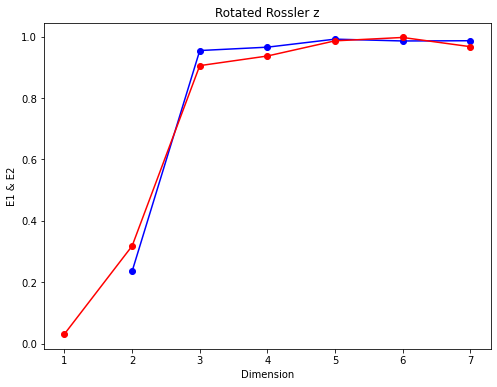

In [32]:
E1, E2 = sp.cao97(timeSeries = rotated_rossler_r[:5000,2], tau = 157, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rotated Rossler z')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rotated_rossler_z.png")

### Lorenz

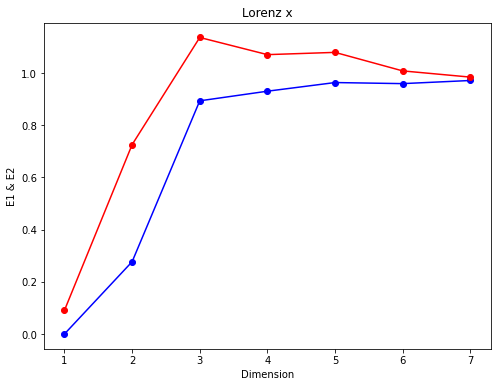

In [30]:
E1, E2 = sp.cao97(timeSeries = lorenz_r[:5000,0], tau = 15, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Lorenz x')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/lorenz_x.png")

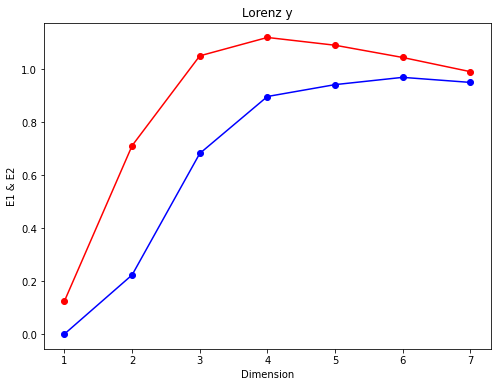

In [31]:
E1, E2 = sp.cao97(timeSeries = lorenz_r[:5000,1], tau = 14, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Lorenz y')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/lorenz_y.png")

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


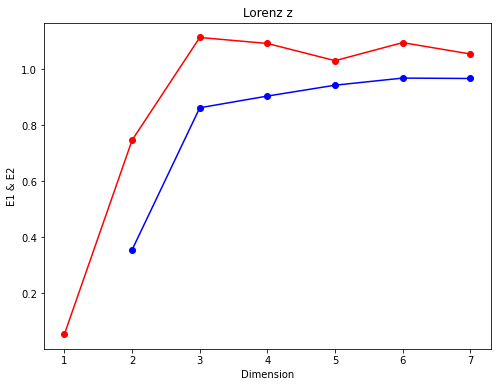

In [32]:
E1, E2 = sp.cao97(timeSeries = lorenz_r[:5000,2], tau = 15, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Lorenz z')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/lorenz_z.png")

### Gaussian noise

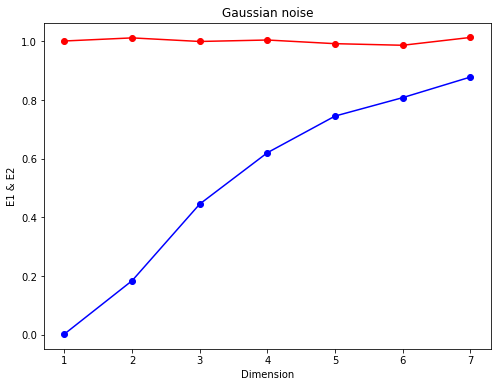

In [33]:
E1, E2 = sp.cao97(timeSeries = gaussianNoise[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Gaussian noise')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/gaussian_noise.png")

### Simple periodic

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


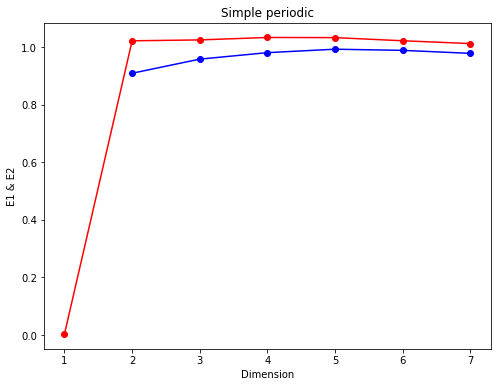

In [34]:
E1, E2 = sp.cao97(timeSeries = simplePeriodic[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Simple periodic')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/simple_periodic.png")

### Kovacs & Buchler 1988

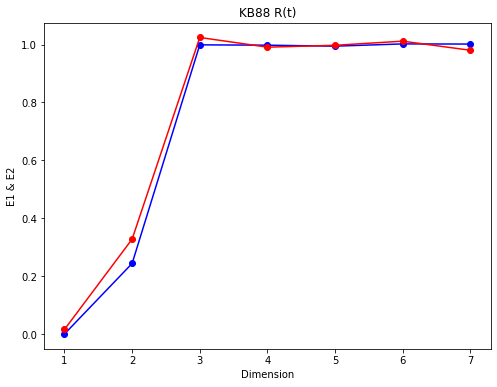

In [35]:
E1, E2 = sp.cao97(timeSeries = multiPeriodic_r[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('KB88 R(t)')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/multiperiodic_r.png")

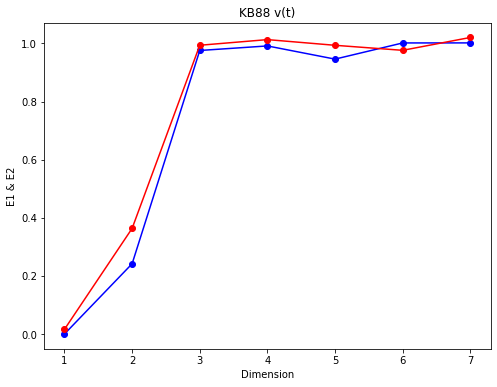

In [36]:
E1, E2 = sp.cao97(timeSeries = multiPeriodic_v[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('KB88 v(t)')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/multiperiodic_v.png")

### Reproduce Cao 1997 fig 4 (correlated noise)

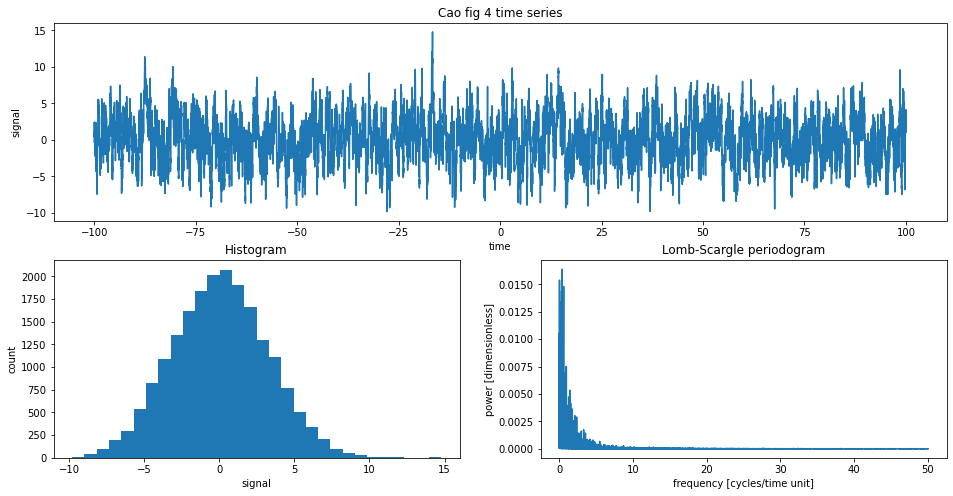

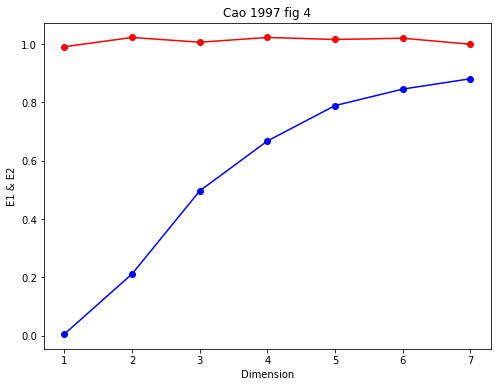

In [37]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise2 = np.random.normal(0.,1.,len(t))

caoFig4 = np.zeros_like(t)
caoFig4[0] = gaussianNoise2[0]
for i in range(1, len(t)):
    caoFig4[i] = caoFig4[i-1]*0.95 + gaussianNoise2[i]
sp.plotTimeSeries(t, caoFig4,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Cao fig 4")

# Cao used tau = 1 for this data, because it's a map rather than a continous diff EQ
E1, E2 = sp.cao97(timeSeries = caoFig4[:5000], tau = 1, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Cao 1997 fig 4')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/cao1997fig4.png")

# Calculate correlation integral

### Grassberger & Procaccia 1983

#### They advocate choosing an embedding dimension larger than strictly necessary to reduce error--interesting!

### Start with Kurths & Herzel 1987, actually.

In [23]:

logrArr = np.linspace(-4.,6.,50)
rArr = 2.**logrArr
#np.save("./corrDimTesting/rArr.npy", rArr)

#np.save("./corrDimTesting/lorenz_x_1000_v0.npy", lorenz_r[:1000,0])
#np.save("./corrDimTesting/lorenz_x_5000_v0.npy", lorenz_r[:5000,0])
#np.save("./corrDimTesting/lorenz_x_10000_v0.npy", lorenz_r[:10000,0])
#np.save("./corrDimTesting/lorenz_x_20000_v0.npy", lorenz_r[:20000,0])

In [16]:
"""
start = time.time()
C0_1000_t15_m3, C1_1000_t15_m3, C2_1000_t15_m3, nArr_1000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:1000,0], tau = 15, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_5000_t15_m3, C1_5000_t15_m3, C2_5000_t15_m3, nArr_5000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:5000,0], tau = 15, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_10000_t15_m3, C1_10000_t15_m3, C2_10000_t15_m3, nArr_10000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:10000,0], tau = 15, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_20000_t15_m3, C1_20000_t15_m3, C2_20000_t15_m3, nArr_20000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:20000,0], tau = 15, m = 3)
end = time.time()
print((end-start)/60.)
"""

0.10095853408177693
8.393945968151092


'\nstart = time.time()\nC0_10000_t15_m3, C1_10000_t15_m3, C2_10000_t15_m3, nArr_10000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:10000,0], tau = 15, m = 3)\nend = time.time()\nprint((end-start)/60.)\n\nstart = time.time()\nC0_20000_t15_m3, C1_20000_t15_m3, C2_20000_t15_m3, nArr_20000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:20000,0], tau = 15, m = 3)\nend = time.time()\nprint((end-start)/60.)\n'

In [17]:
# note: these correspond to r array np.linspace(-4.,6.,50)
"""
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=3_C0.npy",C0_1000_t15_m3)
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=3_C1.npy",C1_1000_t15_m3)
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=3_C2.npy",C2_1000_t15_m3)

np.save("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=3_C0.npy",C0_5000_t15_m3)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=3_C1.npy",C1_5000_t15_m3)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=3_C2.npy",C2_5000_t15_m3)

np.save("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=3_C0.npy",C0_10000_t15_m3)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=3_C1.npy",C1_10000_t15_m3)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=3_C2.npy",C2_10000_t15_m3)

np.save("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=3_C0.npy",C0_20000_t15_m3)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=3_C1.npy",C1_20000_t15_m3)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=3_C2.npy",C2_20000_t15_m3)


# save nArrs
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=3_nArr.npy",nArr_1000_t15_m3)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=3_nArr.npy",nArr_5000_t15_m3)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=3_nArr.npy",nArr_10000_t15_m3)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=3_nArr.npy",nArr_20000_t15_m3)
"""
# save neighbor distances
#np.save("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=3_nd.npy", nd_1000_t15_m3)


In [18]:
"""
start = time.time()
C0_1000_t60_m3, C1_1000_t60_m3, C2_1000_t60_m3, nArr_1000_t60_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:1000,0], tau = 60, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_5000_t60_m3, C1_5000_t60_m3, C2_5000_t60_m3, nArr_5000_t60_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:5000,0], tau = 60, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_10000_t60_m3, C1_10000_t60_m3, C2_10000_t60_m3, nArr_10000_t60_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:10000,0], tau = 60, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_20000_t60_m3, C1_20000_t60_m3, C2_20000_t60_m3, nArr_20000_t60_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:20000,0], tau = 60, m = 3)
end = time.time()
print((end-start)/60.)
"""

0.10091696580251058
10.356032113234201
86.4727066318194
30.77366496324539


In [19]:
# note: these correspond to r array np.linspace(-4.,6.,50)
"""
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=3_C0.npy",C0_1000_t60_m3)
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=3_C1.npy",C1_1000_t60_m3)
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=3_C2.npy",C2_1000_t60_m3)

np.save("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=3_C0.npy",C0_5000_t60_m3)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=3_C1.npy",C1_5000_t60_m3)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=3_C2.npy",C2_5000_t60_m3)

np.save("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=3_C0.npy",C0_10000_t60_m3)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=3_C1.npy",C1_10000_t60_m3)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=3_C2.npy",C2_10000_t60_m3)

np.save("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=3_C0.npy",C0_20000_t60_m3)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=3_C1.npy",C1_20000_t60_m3)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=3_C2.npy",C2_20000_t60_m3)

#save nArrs
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=3_nArr.npy",nArr_1000_t60_m3)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=3_nArr.npy",nArr_5000_t60_m3)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=3_nArr.npy",nArr_10000_t60_m3)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=3_nArr.npy",nArr_20000_t60_m3)
"""
# save neighbor distances
#np.save("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=3_nd.npy", nd_1000_t60_m3)


In [20]:
"""
start = time.time()
C0_1000_t15_m4, C1_1000_t15_m4, C2_1000_t15_m4, nArr_1000_t15_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:1000,0], tau = 15, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_5000_t15_m4, C1_5000_t15_m4, C2_5000_t15_m4, nArr_5000_t15_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:5000,0], tau = 15, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_10000_t15_m4, C1_10000_t15_m4, C2_10000_t15_m4, nArr_10000_t15_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:10000,0], tau = 15, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_20000_t15_m4, C1_20000_t15_m4, C2_20000_t15_m4, nArr_20000_t15_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:20000,0], tau = 15, m = 4)
end = time.time()
print((end-start)/60.)
"""

0.092903204758962
9.631280732154845
90.11337380011877
36.23072103261948


In [21]:
# note: these correspond to r array np.linspace(-4.,6.,50)
"""
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=4_C0.npy",C0_1000_t15_m4)
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=4_C1.npy",C1_1000_t15_m4)
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=4_C2.npy",C2_1000_t15_m4)

np.save("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=4_C0.npy",C0_5000_t15_m4)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=4_C1.npy",C1_5000_t15_m4)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=4_C2.npy",C2_5000_t15_m4)

np.save("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=4_C0.npy",C0_10000_t15_m4)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=4_C1.npy",C1_10000_t15_m4)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=4_C2.npy",C2_10000_t15_m4)

np.save("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=4_C0.npy",C0_20000_t15_m4)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=4_C1.npy",C1_20000_t15_m4)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=4_C2.npy",C2_20000_t15_m4)

#save nArrs
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=4_nArr.npy",nArr_1000_t15_m4)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=4_nArr.npy",nArr_5000_t15_m4)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=4_nArr.npy",nArr_10000_t15_m4)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=4_nArr.npy",nArr_20000_t15_m4)
"""


In [22]:
"""
start = time.time()
C0_1000_t60_m4, C1_1000_t60_m4, C2_1000_t60_m4, nArr_1000_t60_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:1000,0], tau = 60, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_5000_t60_m4, C1_5000_t60_m4, C2_5000_t60_m4, nArr_5000_t60_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:5000,0], tau = 60, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_10000_t60_m4, C1_10000_t60_m4, C2_10000_t60_m4, nArr_10000_t60_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:10000,0], tau = 60, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_20000_t60_m4, C1_20000_t60_m4, C2_20000_t60_m4, nArr_20000_t60_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:20000,0], tau = 60, m = 4)
end = time.time()
print((end-start)/60.)
"""

0.06623845100402832
8.53641718228658
94.11191350221634
51.644079101085666


In [23]:
# note: these correspond to r array np.linspace(-3.5,5.8,50)
"""
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=4_C0.npy",C0_1000_t60_m4)
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=4_C1.npy",C1_1000_t60_m4)
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=4_C2.npy",C2_1000_t60_m4)

np.save("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=4_C0.npy",C0_5000_t60_m4)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=4_C1.npy",C1_5000_t60_m4)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=4_C2.npy",C2_5000_t60_m4)

np.save("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=4_C0.npy",C0_10000_t60_m4)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=4_C1.npy",C1_10000_t60_m4)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=4_C2.npy",C2_10000_t60_m4)

np.save("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=4_C0.npy",C0_20000_t60_m4)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=4_C1.npy",C1_20000_t60_m4)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=4_C2.npy",C2_20000_t60_m4)

#save nArrs
np.save("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=4_nArr.npy",nArr_1000_t60_m4)
np.save("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=4_nArr.npy",nArr_5000_t60_m4)
np.save("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=4_nArr.npy",nArr_10000_t60_m4)
np.save("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=4_nArr.npy",nArr_20000_t60_m4)
"""


In [33]:
rArr = np.load("./corrDimTesting/rArr.npy")
C0_1000_t15_m3 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=3_C0.npy")
C0_5000_t15_m3 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=3_C0.npy")
C0_10000_t15_m3 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=3_C0.npy")
C0_20000_t15_m3 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=3_C0.npy")

C0_1000_t60_m3 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=3_C0.npy")
C0_5000_t60_m3 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=3_C0.npy")
C0_10000_t60_m3 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=3_C0.npy")
C0_20000_t60_m3 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=3_C0.npy")

C0_1000_t15_m4 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=4_C0.npy")
C0_5000_t15_m4 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=4_C0.npy")
C0_10000_t15_m4 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=4_C0.npy")
C0_20000_t15_m4 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=4_C0.npy")

C0_1000_t60_m4 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=4_C0.npy")
C0_5000_t60_m4 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=4_C0.npy")
C0_10000_t60_m4 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=4_C0.npy")
C0_20000_t60_m4 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=4_C0.npy")

C1_1000_t15_m3 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=3_C1.npy")
C1_5000_t15_m3 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=3_C1.npy")
C1_10000_t15_m3 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=3_C1.npy")
C1_20000_t15_m3 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=3_C1.npy")

C1_1000_t60_m3 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=3_C1.npy")
C1_5000_t60_m3 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=3_C1.npy")
C1_10000_t60_m3 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=3_C1.npy")
C1_20000_t60_m3 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=3_C1.npy")

C1_1000_t15_m4 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=4_C1.npy")
C1_5000_t15_m4 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=4_C1.npy")
C1_10000_t15_m4 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=4_C1.npy")
C1_20000_t15_m4 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=4_C1.npy")

C1_1000_t60_m4 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=4_C1.npy")
C1_5000_t60_m4 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=4_C1.npy")
C1_10000_t60_m4 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=4_C1.npy")
C1_20000_t60_m4 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=4_C1.npy")

C2_1000_t15_m3 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=3_C2.npy")
C2_5000_t15_m3 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=3_C2.npy")
C2_10000_t15_m3 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=3_C2.npy")
C2_20000_t15_m3 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=3_C2.npy")

C2_1000_t60_m3 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=3_C2.npy")
C2_5000_t60_m3 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=3_C2.npy")
C2_10000_t60_m3 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=3_C2.npy")
C2_20000_t60_m3 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=3_C2.npy")

C2_1000_t15_m4 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=4_C2.npy")
C2_5000_t15_m4 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=4_C2.npy")
C2_10000_t15_m4 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=4_C2.npy")
C2_20000_t15_m4 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=4_C2.npy")

C2_1000_t60_m4 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=4_C2.npy")
C2_5000_t60_m4 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=4_C2.npy")
C2_10000_t60_m4 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=4_C2.npy")
C2_20000_t60_m4 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=4_C2.npy")

nArr_1000_t15_m3 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=3_nArr.npy")
nArr_5000_t15_m3 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=3_nArr.npy")
nArr_10000_t15_m3 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=3_nArr.npy")
nArr_20000_t15_m3 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=3_nArr.npy")

nArr_1000_t60_m3 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=3_nArr.npy")
nArr_5000_t60_m3 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=3_nArr.npy")
nArr_10000_t60_m3 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=3_nArr.npy")
nArr_20000_t60_m3 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=3_nArr.npy")

nArr_1000_t15_m4 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=15_m=4_nArr.npy")
nArr_5000_t15_m4 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=15_m=4_nArr.npy")
nArr_10000_t15_m4 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=15_m=4_nArr.npy")
nArr_20000_t15_m4 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=15_m=4_nArr.npy")

nArr_1000_t60_m4 = np.load("./corrDimTesting/lorenz_x_1000_v0_tau=60_m=4_nArr.npy")
nArr_5000_t60_m4 = np.load("./corrDimTesting/lorenz_x_5000_v0_tau=60_m=4_nArr.npy")
nArr_10000_t60_m4 = np.load("./corrDimTesting/lorenz_x_10000_v0_tau=60_m=4_nArr.npy")
nArr_20000_t60_m4 = np.load("./corrDimTesting/lorenz_x_20000_v0_tau=60_m=4_nArr.npy")

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarn

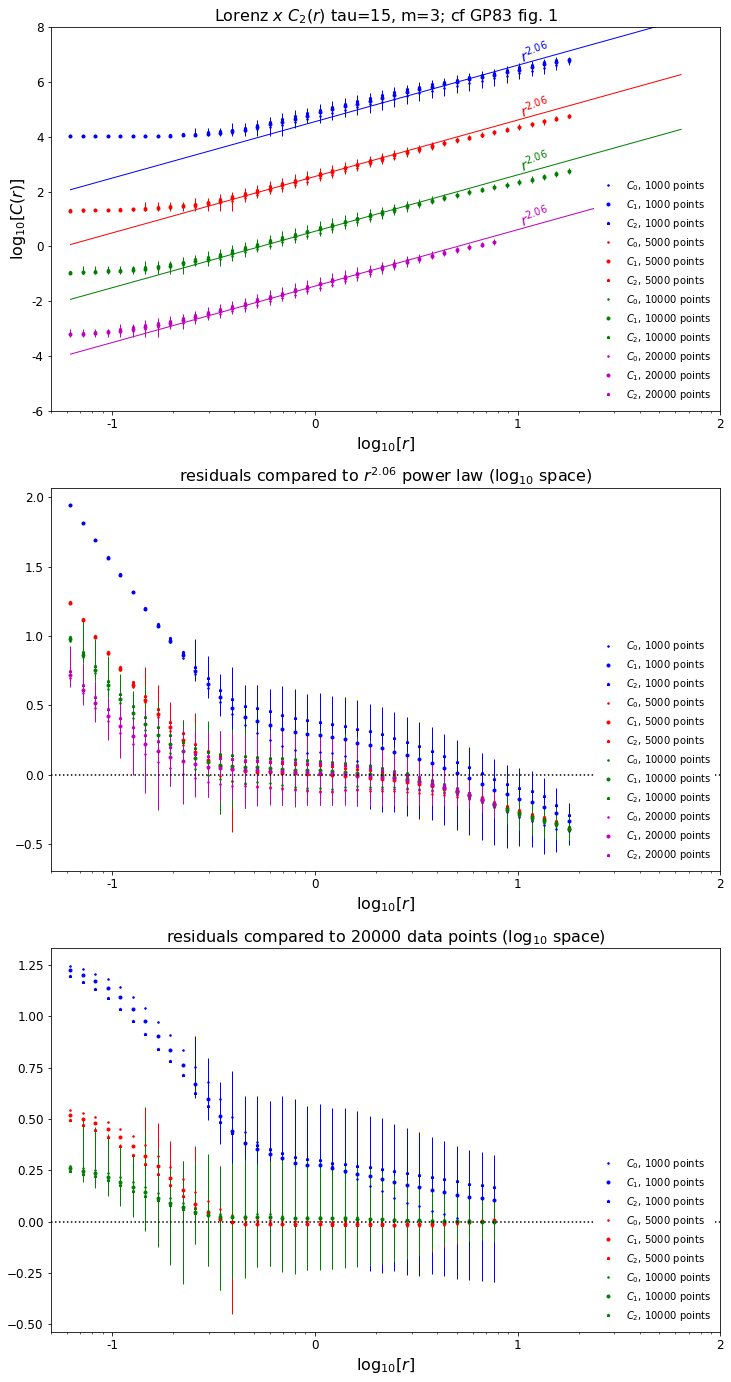

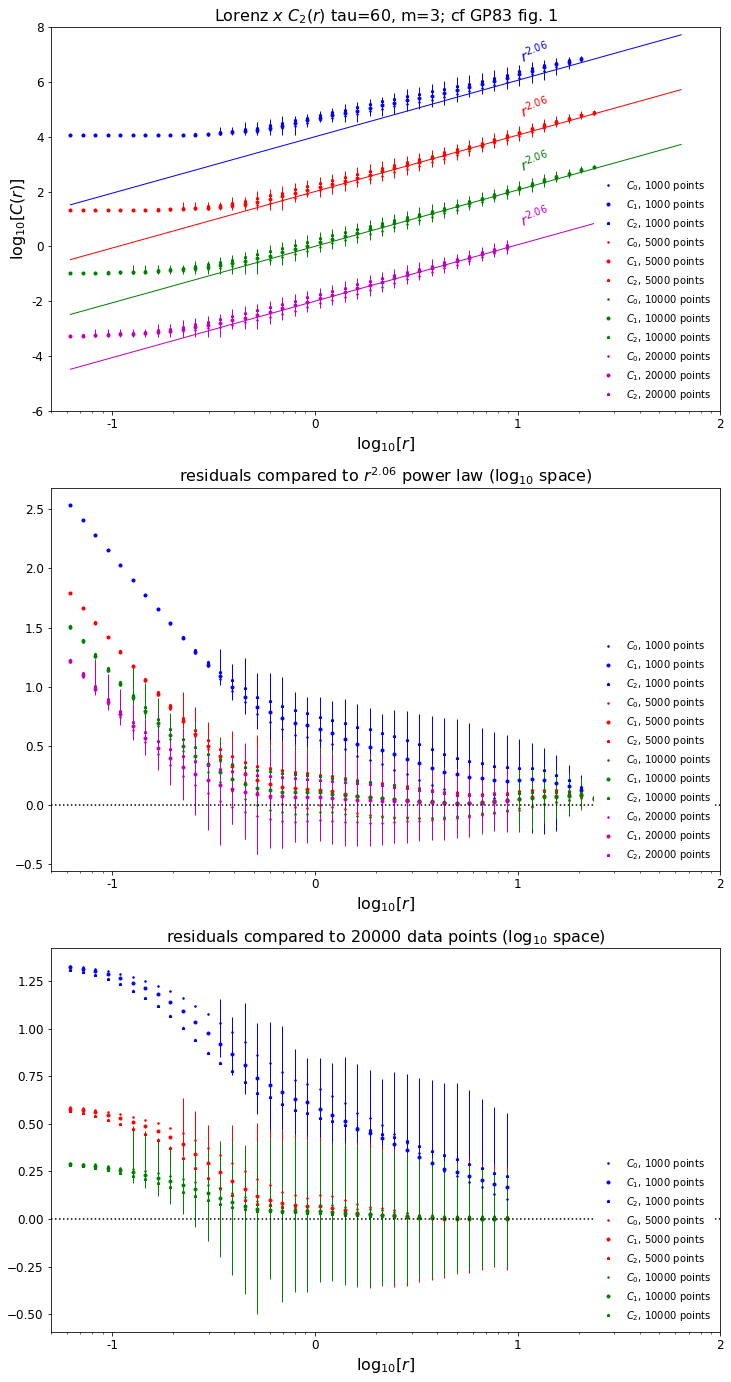

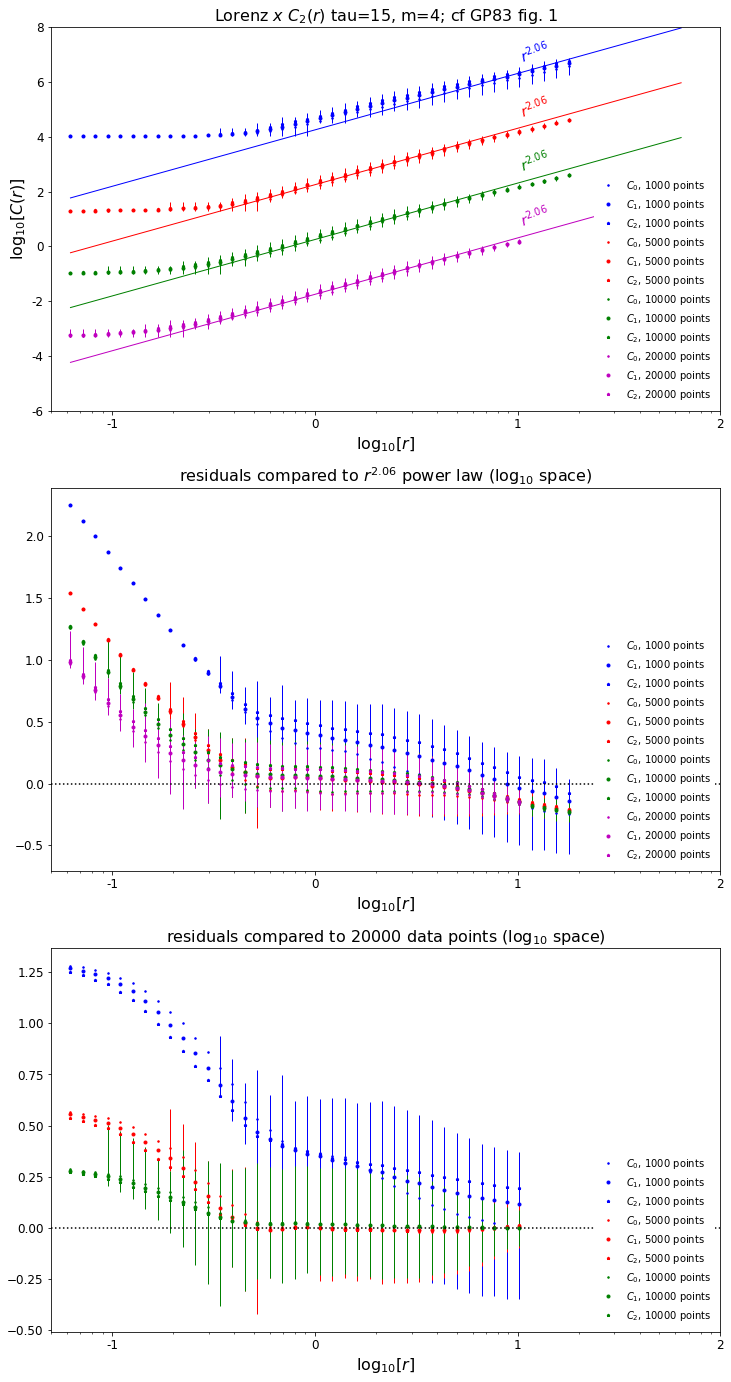

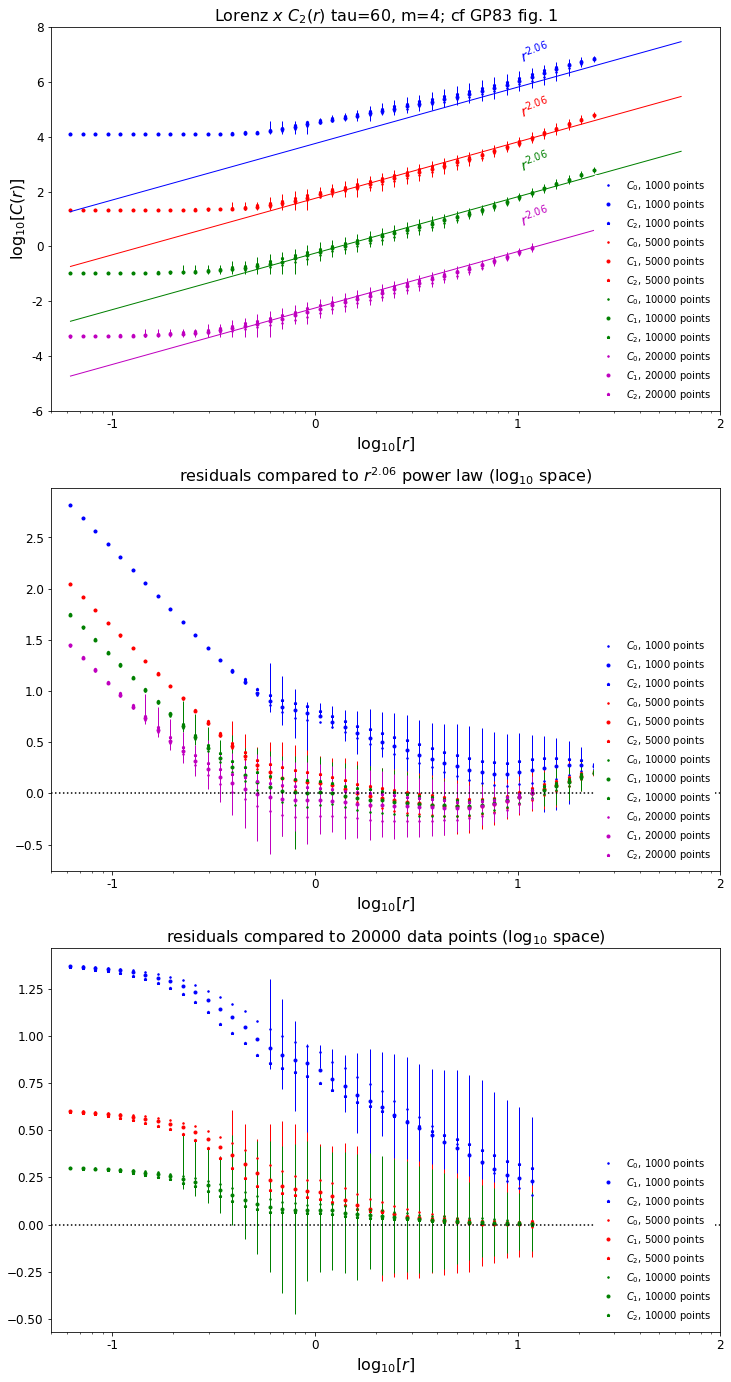

In [20]:
combos = [(15,3),(60,3),(15,4),(60,4)]
C0_1000 = [C0_1000_t15_m3, C0_1000_t60_m3, C0_1000_t15_m4, C0_1000_t60_m4]
C1_1000 = [C1_1000_t15_m3, C1_1000_t60_m3, C1_1000_t15_m4, C1_1000_t60_m4]
C2_1000 = [C2_1000_t15_m3, C2_1000_t60_m3, C2_1000_t15_m4, C2_1000_t60_m4]
n_1000 = [nArr_1000_t15_m3, nArr_1000_t60_m3, nArr_1000_t15_m4, nArr_1000_t60_m4]

C0_5000 = [C0_5000_t15_m3, C0_5000_t60_m3, C0_5000_t15_m4, C0_5000_t60_m4]
C1_5000 = [C1_5000_t15_m3, C1_5000_t60_m3, C1_5000_t15_m4, C1_5000_t60_m4]
C2_5000 = [C2_5000_t15_m3, C2_5000_t60_m3, C2_5000_t15_m4, C2_5000_t60_m4]
n_5000 = [nArr_5000_t15_m3, nArr_5000_t60_m3, nArr_5000_t15_m4, nArr_5000_t60_m4]

C0_10000 = [C0_10000_t15_m3, C0_10000_t60_m3, C0_10000_t15_m4, C0_10000_t60_m4]
C1_10000 = [C1_10000_t15_m3, C1_10000_t60_m3, C1_10000_t15_m4, C1_10000_t60_m4]
C2_10000 = [C2_10000_t15_m3, C2_10000_t60_m3, C2_10000_t15_m4, C2_10000_t60_m4]
n_10000 = [nArr_10000_t15_m3, nArr_10000_t60_m3, nArr_10000_t15_m4, nArr_10000_t60_m4]

C0_20000 = [C0_20000_t15_m3, C0_20000_t60_m3, C0_20000_t15_m4, C0_20000_t60_m4]
C1_20000 = [C1_20000_t15_m3, C1_20000_t60_m3, C1_20000_t15_m4, C1_20000_t60_m4]
C2_20000 = [C2_20000_t15_m3, C2_20000_t60_m3, C2_20000_t15_m4, C2_20000_t60_m4]
n_20000 = [nArr_20000_t15_m3, nArr_20000_t60_m3, nArr_20000_t15_m4, nArr_20000_t60_m4]

# vertical offsets for the different-length time series
vOffset = [10**7, 10**5, 10**3, 10**1]

# adjustments to vertical offsets for the different choices of tau and m
bOffset = [10**-2.45,10**-3,10**-2.75,10**-3.25]
Narr = [(970,4970,9970,19970),(880,4880,9880,19880),(955,4995,9955,19955),(820,4820,9820,19820)]


for i, combo in enumerate(combos):
    t = combo[0]
    m = combo[1]
    
    p84_1000 = np.percentile(n_1000[i], 84, axis=0)
    p50_1000 = np.percentile(n_1000[i], 50, axis=0)
    p16_1000 = np.percentile(n_1000[i], 16, axis=0)
    
    p84_5000 = np.percentile(n_5000[i], 84, axis=0)
    p50_5000 = np.percentile(n_5000[i], 50, axis=0)
    p16_5000 = np.percentile(n_5000[i], 16, axis=0)
    
    p84_10000 = np.percentile(n_10000[i], 84, axis=0)
    p50_10000 = np.percentile(n_10000[i], 50, axis=0)
    p16_10000 = np.percentile(n_10000[i], 16, axis=0)
    
    p84_20000 = np.percentile(n_20000[i], 84, axis=0)
    p50_20000 = np.percentile(n_20000[i], 50, axis=0)
    p16_20000 = np.percentile(n_20000[i], 16, axis=0)
    
    fig, axes = plt.subplots(3,1,figsize=(12,24))
    
    axes[0].plot(rArr,C0_1000[i] * vOffset[0],color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")    
    axes[0].plot(rArr,C1_1000[i] * vOffset[0],color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[0].plot(rArr,C2_1000[i] * vOffset[0],color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[0].vlines(x=rArr, ymin=p16_1000 * vOffset[0], ymax=p84_1000 * vOffset[0], color='b',lw=1)
    
    axes[0].plot(rArr,C0_5000[i] * vOffset[1],color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[0].plot(rArr,C1_5000[i] * vOffset[1],color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[0].plot(rArr,C2_5000[i] * vOffset[1],color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[0].vlines(x=rArr, ymin=p16_5000 * vOffset[1], ymax=p84_5000 * vOffset[1], color='r',lw=1)
    
    axes[0].plot(rArr,C0_10000[i]* vOffset[2],color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[0].plot(rArr,C1_10000[i]* vOffset[2],color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[0].plot(rArr,C2_10000[i]* vOffset[2],color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[0].vlines(x=rArr, ymin=p16_10000 * vOffset[2], ymax=p84_10000 * vOffset[2], color='g',lw=1)
    
    axes[0].plot(rArr,C0_20000[i]* vOffset[3],color='m',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 20000 points")
    axes[0].plot(rArr,C1_20000[i]* vOffset[3],color='m',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 20000 points")
    axes[0].plot(rArr,C2_20000[i]* vOffset[3],color='m',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 20000 points")
    axes[0].vlines(x=rArr, ymin=p16_20000 * vOffset[3], ymax=p84_20000 * vOffset[3], color='m',lw=1)
    
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[0],'b-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[1],'r-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[2],'g-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[3],'m-',lw=1)

    axes[0].text(10.,vOffset[0]*0.5,r"$r^{2.06}$",color='b',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[1]*0.5,r"$r^{2.06}$",color='r',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[2]*0.5,r"$r^{2.06}$",color='g',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[3]*0.5,r"$r^{2.06}$",color='m',fontsize=14,rotation=20)
    
    axes[0].set_ylabel(r"$\log_{10}[C(r)]$", fontsize=16)
    axes[0].set_title(r"Lorenz $x$ $C_2(r)$ tau={0}, m={1}; cf GP83 fig. 1".format(t,m),fontsize=16)
    axes[0].set_yscale("log")
    axes[0].set_ylim(1.e-6,1.e8)
    axes[0].set_yticklabels([-8,-6,-4,-2,0,2,4,6,8])
    
    # residuals compared to power law
    axes[1].plot(rArr,np.log10(C0_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")
    axes[1].plot(rArr,np.log10(C1_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[1].plot(rArr,np.log10(C2_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_1000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_1000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='b',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[1].plot(rArr,np.log10(C1_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[1].plot(rArr,np.log10(C2_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_5000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_5000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='r',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[1].plot(rArr,np.log10(C1_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[1].plot(rArr,np.log10(C2_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_10000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_10000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='g',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 20000 points")
    axes[1].plot(rArr,np.log10(C1_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 20000 points")
    axes[1].plot(rArr,np.log10(C2_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 20000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_20000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_20000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='m',lw=1.,alpha=1)
    
    axes[1].axhline(0,color='k',ls=':')
    axes[1].set_title(r"residuals compared to $r^{2.06}$ power law ($\log_{10}$ space)",fontsize=16)
    
    # residuals compared to 20000 data points
    axes[2].plot(rArr,np.log10(C0_1000[i]) - np.log10(C0_20000[i]),color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")
    axes[2].plot(rArr,np.log10(C1_1000[i]) - np.log10(C1_20000[i]),color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[2].plot(rArr,np.log10(C2_1000[i]) - np.log10(C2_20000[i]),color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_1000)-np.log10(C1_20000[i]), ymax=np.log10(p84_1000)-np.log10(C1_20000[i]), color='b',lw=1.,alpha=1)
    
    axes[2].plot(rArr,np.log10(C0_5000[i]) - np.log10(C0_20000[i]),color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[2].plot(rArr,np.log10(C1_5000[i]) - np.log10(C1_20000[i]),color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[2].plot(rArr,np.log10(C2_5000[i]) - np.log10(C2_20000[i]),color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_5000)-np.log10(C1_20000[i]), ymax=np.log10(p84_5000)-np.log10(C1_20000[i]), color='r',lw=1.,alpha=1)
    
    axes[2].plot(rArr,np.log10(C0_10000[i]) - np.log10(C0_20000[i]),color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[2].plot(rArr,np.log10(C1_10000[i]) - np.log10(C1_20000[i]),color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[2].plot(rArr,np.log10(C2_10000[i]) - np.log10(C2_20000[i]),color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_10000)-np.log10(C1_20000[i]), ymax=np.log10(p84_10000)-np.log10(C1_20000[i]), color='g',lw=1.,alpha=1)
    
    axes[2].axhline(0,color='k',ls=':')
    axes[2].set_title(r"residuals compared to 20000 data points ($\log_{10}$ space)",fontsize=16)
    

    for ax in axes:
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_xlabel(r"$\log_{10}[r]$", fontsize=16)
        ax.set_xscale("log")
        ax.set_xlim(5.e-2,1.e2)
        ax.set_xticklabels([-3,-2,-1,0,1,2])
        ax.legend(loc="lower right",frameon=True,framealpha=1.0, edgecolor='None')
    
    #plt.show()
    plt.savefig("./plots/gp1983implementation/lorenz_x_timeSeriesLength_tau={0}_m={1}.pdf".format(t,m))
    

In [21]:
x = np.arange(10)
y = 3.*x + 5 + np.random.normal(0.,0.5,size=len(x))

b,Bunc = sp.normal_equation(x, y, 0.5*np.ones_like(y), 2)
print(b)
print(Bunc)

[2.99043774 5.24060761]
[[ 0.0030303  -0.01363636]
 [-0.01363636  0.08636364]]


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


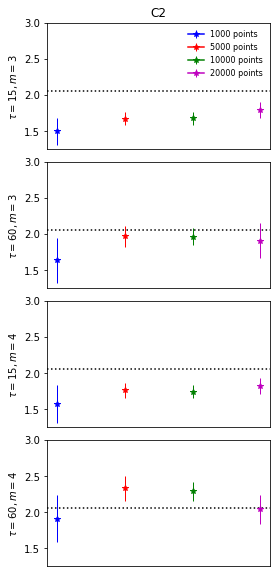

In [22]:
fig, axes = plt.subplots(4,1,figsize=(4,10))#plt.subplots(4,3,figsize=(8,8))

for i, combo in enumerate(combos):
    t = combo[0]
    m = combo[1]
    """
    params_1000_C0, params_unc_1000_C0 = sp.fitLinearRegime(rArr, n_1000[i], C0_1000[i])
    params_5000_C0, params_unc_5000_C0 = sp.fitLinearRegime(rArr, n_5000[i], C0_5000[i])
    params_10000_C0, params_unc_10000_C0 = sp.fitLinearRegime(rArr, n_10000[i], C0_10000[i])
    params_20000_C0, params_unc_20000_C0 = sp.fitLinearRegime(rArr, n_20000[i], C0_20000[i])
    
    params_1000_C1, params_unc_1000_C1 = sp.fitLinearRegime(rArr, n_1000[i], C1_1000[i])
    params_5000_C1, params_unc_5000_C1 = sp.fitLinearRegime(rArr, n_5000[i], C1_5000[i])
    params_10000_C1, params_unc_10000_C1 = sp.fitLinearRegime(rArr, n_10000[i], C1_10000[i])
    params_20000_C1, params_unc_20000_C1 = sp.fitLinearRegime(rArr, n_20000[i], C1_20000[i])
    """
    params_1000_C2, params_unc_1000_C2 = sp.fitLinearRegime(rArr, n_1000[i], C2_1000[i])
    params_5000_C2, params_unc_5000_C2 = sp.fitLinearRegime(rArr, n_5000[i], C2_5000[i])
    params_10000_C2, params_unc_10000_C2 = sp.fitLinearRegime(rArr, n_10000[i], C2_10000[i])
    params_20000_C2, params_unc_20000_C2 = sp.fitLinearRegime(rArr, n_20000[i], C2_20000[i])
    """
    axes[i,0].axhline(2.06,color='k',linestyle=":")
    axes[i,0].errorbar(1, params_1000_C0[0], np.sqrt(params_unc_1000_C0[0,0]), marker='.', color='b', elinewidth=1,label='1000 points')
    axes[i,0].errorbar(2, params_5000_C0[0], np.sqrt(params_unc_5000_C0[0,0]), marker='.', color='r', elinewidth=1, label='5000 points')
    axes[i,0].errorbar(3, params_10000_C0[0], np.sqrt(params_unc_10000_C0[0,0]), marker='.', color='g', elinewidth=1, label='10000 points')
    axes[i,0].errorbar(4, params_20000_C0[0], np.sqrt(params_unc_20000_C0[0,0]), marker='.', color='m', elinewidth=1, label='20000 points')
    axes[i,0].set_ylabel(r"$\tau = {0}, m = {1}$ ".format(t,m))
    axes[i,0].set_xticks([])
    axes[i,0].set_ylim(1.25,3)
    
    axes[i,1].axhline(2.06,color='k',linestyle=":")
    axes[i,1].errorbar(1, params_1000_C1[0], np.sqrt(params_unc_1000_C1[0,0]), marker='o', color='b', elinewidth=1,label='1000 points')
    axes[i,1].errorbar(2, params_5000_C1[0], np.sqrt(params_unc_5000_C1[0,0]), marker='o', color='r', elinewidth=1, label='5000 points')
    axes[i,1].errorbar(3, params_10000_C1[0], np.sqrt(params_unc_10000_C1[0,0]), marker='o', color='g', elinewidth=1, label='10000 points')
    axes[i,1].errorbar(4, params_20000_C1[0], np.sqrt(params_unc_20000_C1[0,0]), marker='o', color='m', elinewidth=1, label='20000 points')
    axes[i,1].set_xticks([])
    axes[i,1].set_ylim(1.25,3)
    """
    axes[i].axhline(2.06,color='k',linestyle=":")
    axes[i].errorbar(1, params_1000_C2[0], np.sqrt(params_unc_1000_C2[0,0]), marker='*', color='b', elinewidth=1,label='1000 points')
    axes[i].errorbar(2, params_5000_C2[0], np.sqrt(params_unc_5000_C2[0,0]), marker='*', color='r', elinewidth=1, label='5000 points')
    axes[i].errorbar(3, params_10000_C2[0], np.sqrt(params_unc_10000_C2[0,0]), marker='*', color='g', elinewidth=1, label='10000 points')
    axes[i].errorbar(4, params_20000_C2[0], np.sqrt(params_unc_20000_C2[0,0]), marker='*', color='m', elinewidth=1, label='20000 points')
    axes[i].set_xticks([])
    axes[i].set_ylabel(r"$\tau = {0}, m = {1}$ ".format(t,m))
    axes[i].set_ylim(1.25,3)
    
axes[0].legend(fontsize=8,loc='upper right', frameon=False)

#axes[0,0].set_title("C0")
#axes[0,1].set_title("C1")
axes[0].set_title("C2")
plt.subplots_adjust(hspace=0.1,wspace=0.4)
#plt.show()
plt.savefig("./plots/gp1983implementation/lorenz_x_recoveredPowerLawSlope.pdf")
    

# Automate the above. 

In [21]:
"""
np.save("./corrDimTesting/lorenz_x_1000_v1.npy", lorenz_r[5000:6000,0])
np.save("./corrDimTesting/lorenz_x_1000_v2.npy", lorenz_r[10000:11000,0])

np.save("./corrDimTesting/lorenz_x_5000_v1.npy", lorenz_r[5000:10000,0])
np.save("./corrDimTesting/lorenz_x_5000_v2.npy", lorenz_r[10000:15000,0])

np.save("./corrDimTesting/lorenz_y_1000_v0.npy", lorenz_r[0:1000,1])
np.save("./corrDimTesting/lorenz_y_1000_v1.npy", lorenz_r[5000:6000,1])
np.save("./corrDimTesting/lorenz_y_1000_v2.npy", lorenz_r[10000:11000,1])

np.save("./corrDimTesting/lorenz_y_5000_v0.npy", lorenz_r[0:5000,1])
np.save("./corrDimTesting/lorenz_y_5000_v1.npy", lorenz_r[5000:10000,1])
np.save("./corrDimTesting/lorenz_y_5000_v2.npy", lorenz_r[10000:15000,1])

np.save("./corrDimTesting/lorenz_z_1000_v0.npy", lorenz_r[0:1000,2])
np.save("./corrDimTesting/lorenz_z_1000_v1.npy", lorenz_r[5000:6000,2])
np.save("./corrDimTesting/lorenz_z_1000_v2.npy", lorenz_r[10000:11000,2])

np.save("./corrDimTesting/lorenz_z_5000_v0.npy", lorenz_r[0:5000,2])
np.save("./corrDimTesting/lorenz_z_5000_v1.npy", lorenz_r[5000:10000,2])
np.save("./corrDimTesting/lorenz_z_5000_v2.npy", lorenz_r[10000:15000,2])
"""

In [34]:
"""
np.save("./corrDimTesting/rossler_x_1000_v0.npy", rossler_r[0:1000,0])
np.save("./corrDimTesting/rossler_x_1000_v1.npy", rossler_r[5000:6000,0])
np.save("./corrDimTesting/rossler_x_1000_v2.npy", rossler_r[10000:11000,0])

np.save("./corrDimTesting/rossler_x_5000_v0.npy", rossler_r[0:5000,0])
np.save("./corrDimTesting/rossler_x_5000_v1.npy", rossler_r[5000:10000,0])
np.save("./corrDimTesting/rossler_x_5000_v2.npy", rossler_r[10000:15000,0])

np.save("./corrDimTesting/rossler_y_1000_v0.npy", rossler_r[0:1000,1])
np.save("./corrDimTesting/rossler_y_1000_v1.npy", rossler_r[5000:6000,1])
np.save("./corrDimTesting/rossler_y_1000_v2.npy", rossler_r[10000:11000,1])

np.save("./corrDimTesting/rossler_y_5000_v0.npy", rossler_r[0:5000,1])
np.save("./corrDimTesting/rossler_y_5000_v1.npy", rossler_r[5000:10000,1])
np.save("./corrDimTesting/rossler_y_5000_v2.npy", rossler_r[10000:15000,1])

np.save("./corrDimTesting/rossler_z_1000_v0.npy", rossler_r[0:1000,2])
np.save("./corrDimTesting/rossler_z_1000_v1.npy", rossler_r[5000:6000,2])
np.save("./corrDimTesting/rossler_z_1000_v2.npy", rossler_r[10000:11000,2])

np.save("./corrDimTesting/rossler_z_5000_v0.npy", rossler_r[0:5000,2])
np.save("./corrDimTesting/rossler_z_5000_v1.npy", rossler_r[5000:10000,2])
np.save("./corrDimTesting/rossler_z_5000_v2.npy", rossler_r[10000:15000,2])
"""

In [35]:
"""
np.save("./corrDimTesting/rotated_rossler_x_1000_v0.npy", rotated_rossler_r[0:1000,0])
np.save("./corrDimTesting/rotated_rossler_x_1000_v1.npy", rotated_rossler_r[5000:6000,0])
np.save("./corrDimTesting/rotated_rossler_x_1000_v2.npy", rotated_rossler_r[10000:11000,0])

np.save("./corrDimTesting/rotated_rossler_x_5000_v0.npy", rotated_rossler_r[0:5000,0])
np.save("./corrDimTesting/rotated_rossler_x_5000_v1.npy", rotated_rossler_r[5000:10000,0])
np.save("./corrDimTesting/rotated_rossler_x_5000_v2.npy", rotated_rossler_r[10000:15000,0])

np.save("./corrDimTesting/rotated_rossler_y_1000_v0.npy", rotated_rossler_r[0:1000,1])
np.save("./corrDimTesting/rotated_rossler_y_1000_v1.npy", rotated_rossler_r[5000:6000,1])
np.save("./corrDimTesting/rotated_rossler_y_1000_v2.npy", rotated_rossler_r[10000:11000,1])

np.save("./corrDimTesting/rotated_rossler_y_5000_v0.npy", rotated_rossler_r[0:5000,1])
np.save("./corrDimTesting/rotated_rossler_y_5000_v1.npy", rotated_rossler_r[5000:10000,1])
np.save("./corrDimTesting/rotated_rossler_y_5000_v2.npy", rotated_rossler_r[10000:15000,1])

np.save("./corrDimTesting/rotated_rossler_z_1000_v0.npy", rotated_rossler_r[0:1000,2])
np.save("./corrDimTesting/rotated_rossler_z_1000_v1.npy", rotated_rossler_r[5000:6000,2])
np.save("./corrDimTesting/rotated_rossler_z_1000_v2.npy", rotated_rossler_r[10000:11000,2])

np.save("./corrDimTesting/rotated_rossler_z_5000_v0.npy", rotated_rossler_r[0:5000,2])
np.save("./corrDimTesting/rotated_rossler_z_5000_v1.npy", rotated_rossler_r[5000:10000,2])
np.save("./corrDimTesting/rotated_rossler_z_5000_v2.npy", rotated_rossler_r[10000:15000,2])
"""

In [36]:
#mutInfo, bestTau = sp.FS86(timeSeries = lorenz_r[:,0], trialDelayIndices = np.arange(0,500), plot=True)

#E1, E2 = sp.cao97(timeSeries = simplePeriodic[:5000], tau = 162, mMax = 8)

#C0_1000_t60_m4, C1_1000_t60_m4, C2_1000_t60_m4, nArr_1000_t60_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:1000,0], tau = 60, m = 4)

In [37]:
timeSeriesArrs_1000_v0 = ! ls ./corrDimTesting/*1000_v0.npy*
timeSeriesArrs_1000_v1 = ! ls ./corrDimTesting/*1000_v1.npy*
timeSeriesArrs_1000_v2 = ! ls ./corrDimTesting/*1000_v2.npy*
timeSeriesArrs_5000_v0 = ! ls ./corrDimTesting/*5000_v0.npy*
timeSeriesArrs_5000_v1 = ! ls ./corrDimTesting/*5000_v1.npy*
timeSeriesArrs_5000_v2 = ! ls ./corrDimTesting/*5000_v2.npy*
timeSeriesArrs = list(timeSeriesArrs_1000_v0) + list(timeSeriesArrs_1000_v1) + list(timeSeriesArrs_1000_v2) + list(timeSeriesArrs_5000_v0) + list(timeSeriesArrs_5000_v1) + list(timeSeriesArrs_5000_v2) 
#timeSeriesArrs = list(timeSeriesArrs_5000_v0) + list(timeSeriesArrs_5000_v1) + list(timeSeriesArrs_5000_v2) 


In [38]:
print(timeSeriesArrs)
print(len(timeSeriesArrs))

['./corrDimTesting/lorenz_x_1000_v0.npy', './corrDimTesting/lorenz_y_1000_v0.npy', './corrDimTesting/lorenz_z_1000_v0.npy', './corrDimTesting/rossler_x_1000_v0.npy', './corrDimTesting/rossler_y_1000_v0.npy', './corrDimTesting/rossler_z_1000_v0.npy', './corrDimTesting/rotated_rossler_x_1000_v0.npy', './corrDimTesting/rotated_rossler_y_1000_v0.npy', './corrDimTesting/rotated_rossler_z_1000_v0.npy', './corrDimTesting/lorenz_x_1000_v1.npy', './corrDimTesting/lorenz_y_1000_v1.npy', './corrDimTesting/lorenz_z_1000_v1.npy', './corrDimTesting/rossler_x_1000_v1.npy', './corrDimTesting/rossler_y_1000_v1.npy', './corrDimTesting/rossler_z_1000_v1.npy', './corrDimTesting/rotated_rossler_x_1000_v1.npy', './corrDimTesting/rotated_rossler_y_1000_v1.npy', './corrDimTesting/rotated_rossler_z_1000_v1.npy', './corrDimTesting/lorenz_x_1000_v2.npy', './corrDimTesting/lorenz_y_1000_v2.npy', './corrDimTesting/lorenz_z_1000_v2.npy', './corrDimTesting/rossler_x_1000_v2.npy', './corrDimTesting/rossler_y_1000_v2.

./corrDimTesting/lorenz_x_1000_v0.npy


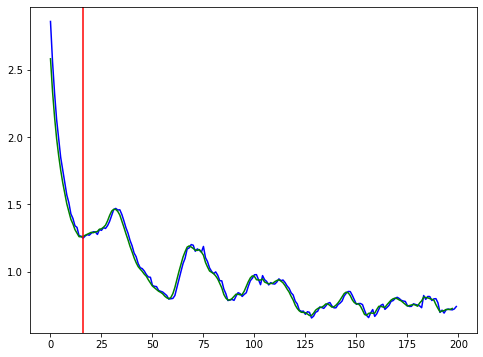

./corrDimTesting/lorenz_y_1000_v0.npy


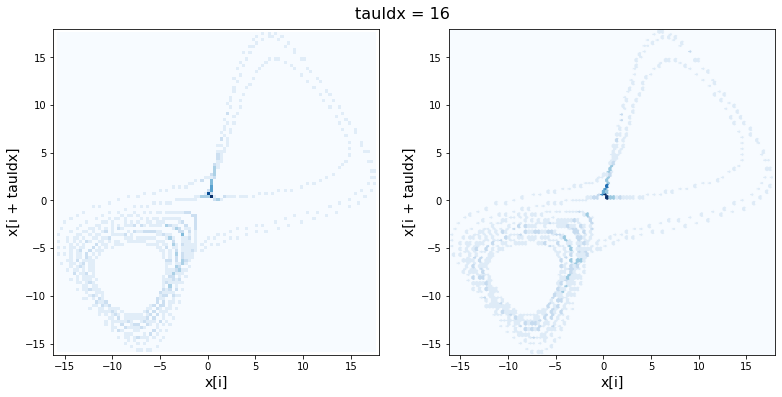

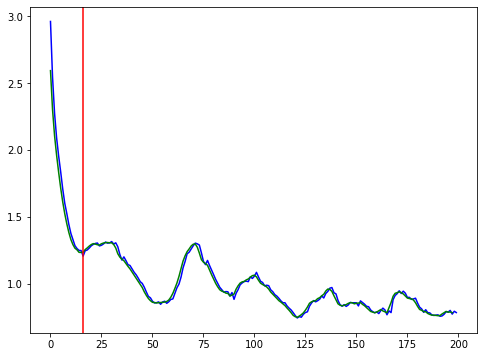

./corrDimTesting/lorenz_z_1000_v0.npy


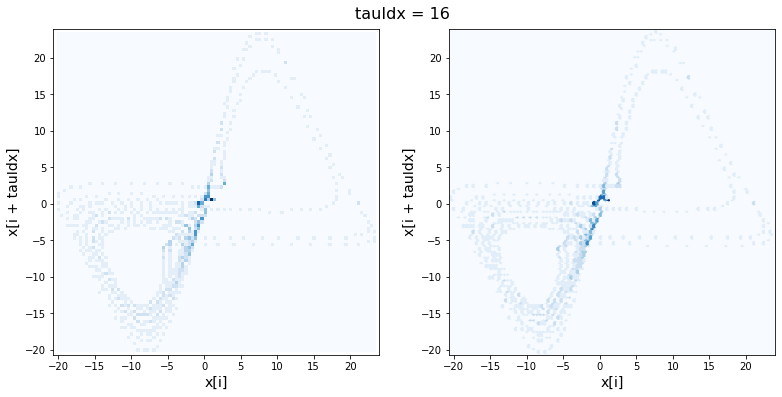

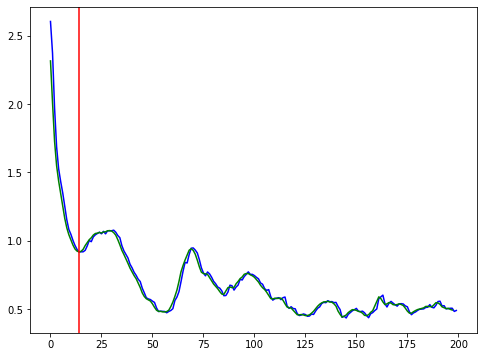

./corrDimTesting/rossler_x_1000_v0.npy


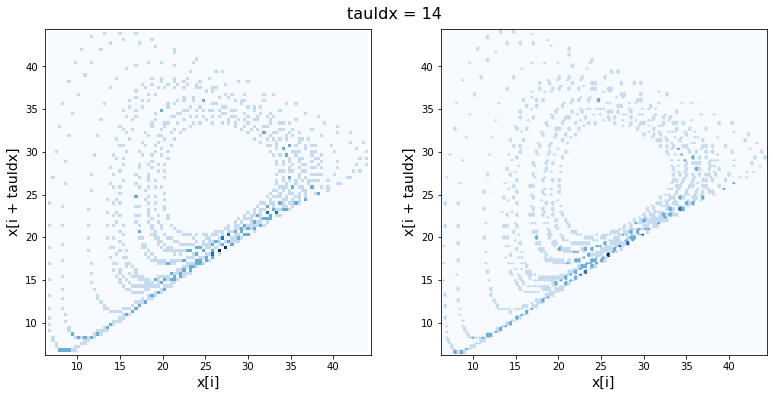

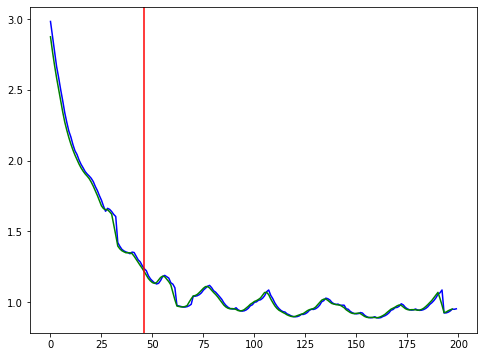

./corrDimTesting/rossler_y_1000_v0.npy


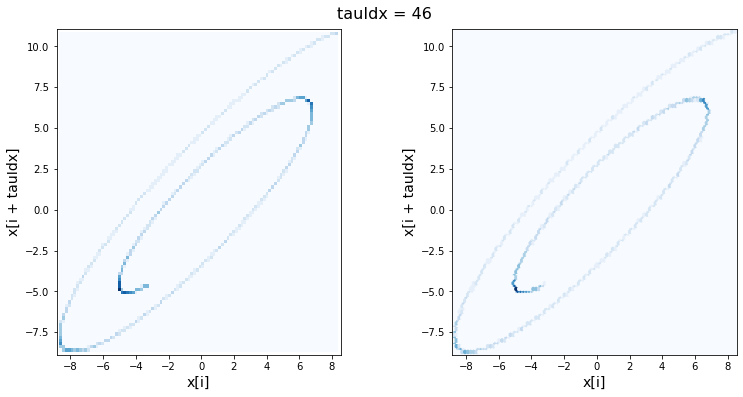

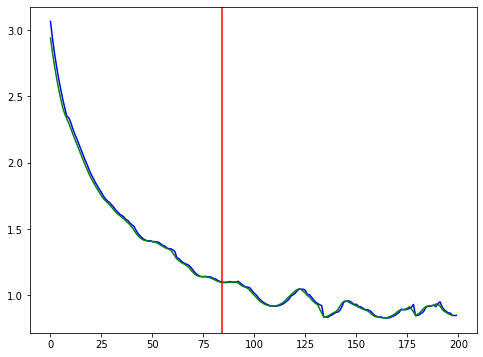

./corrDimTesting/rossler_z_1000_v0.npy


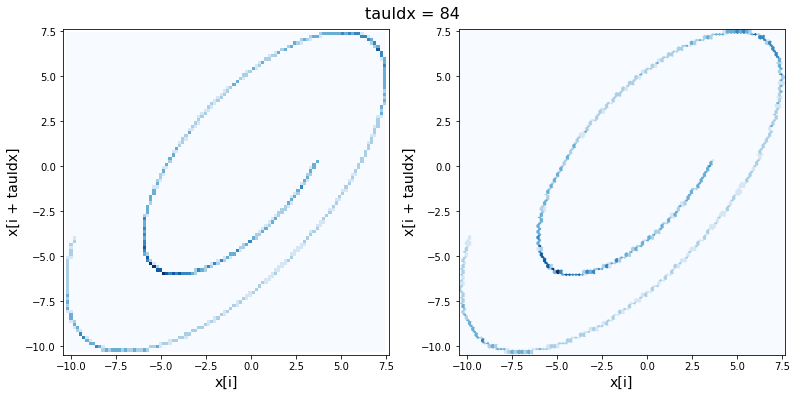

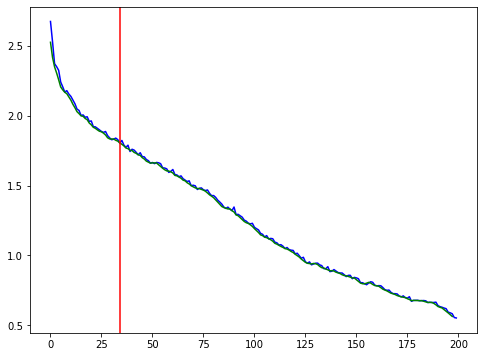

./corrDimTesting/rotated_rossler_x_1000_v0.npy


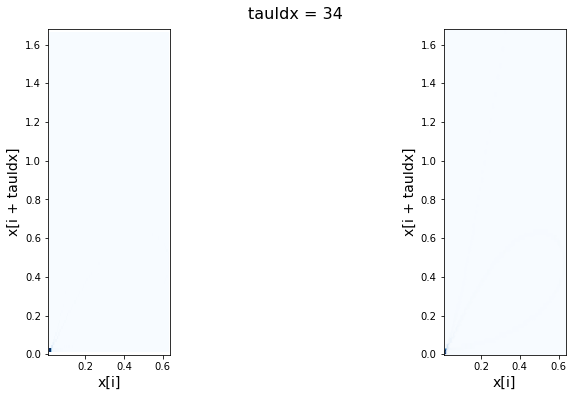

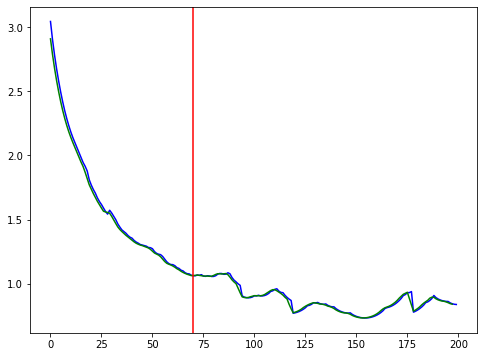

./corrDimTesting/rotated_rossler_y_1000_v0.npy


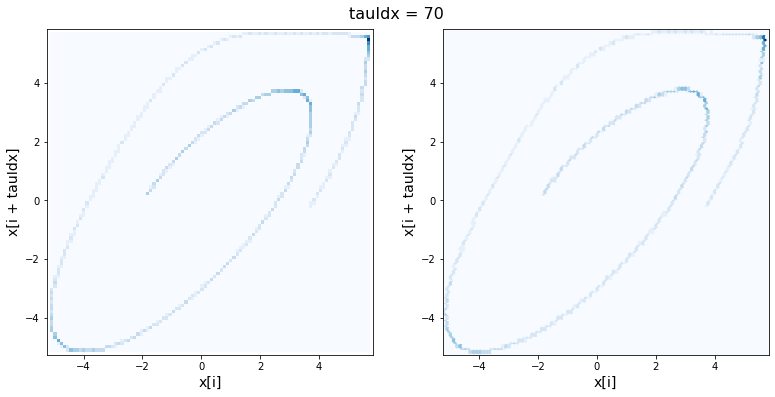

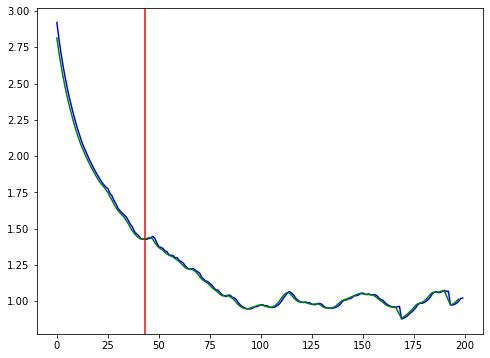

./corrDimTesting/rotated_rossler_z_1000_v0.npy


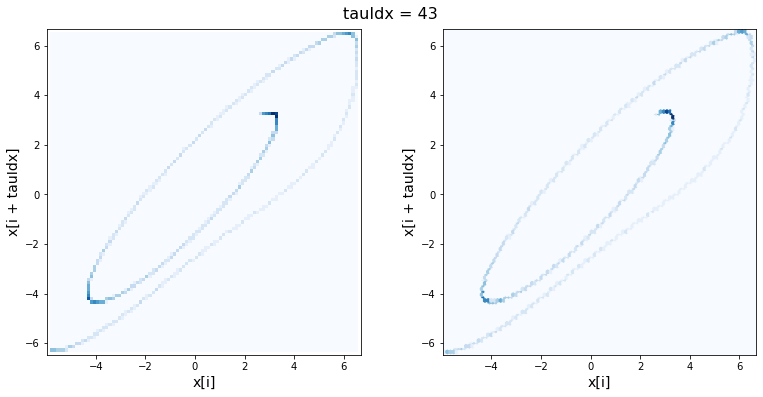

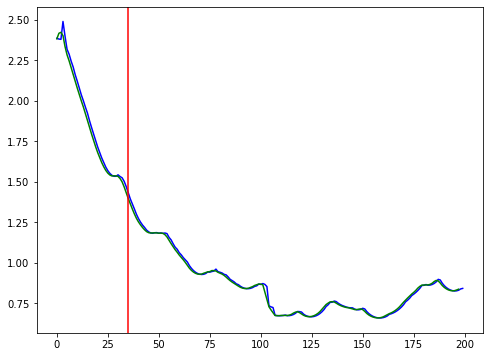

./corrDimTesting/lorenz_x_1000_v1.npy


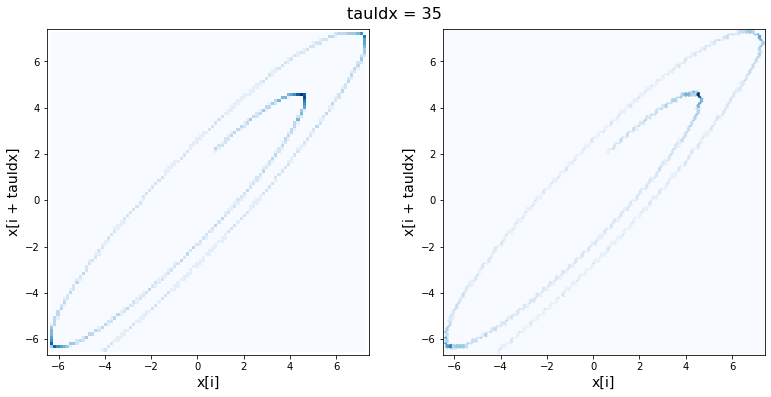

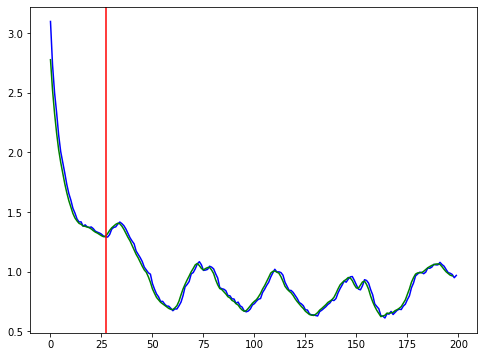

./corrDimTesting/lorenz_y_1000_v1.npy


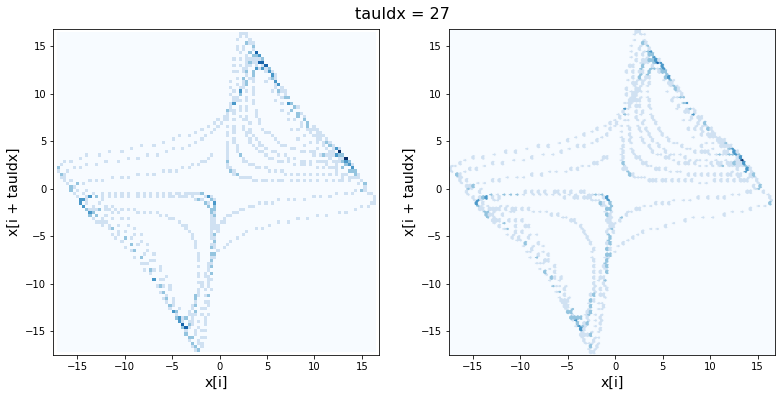

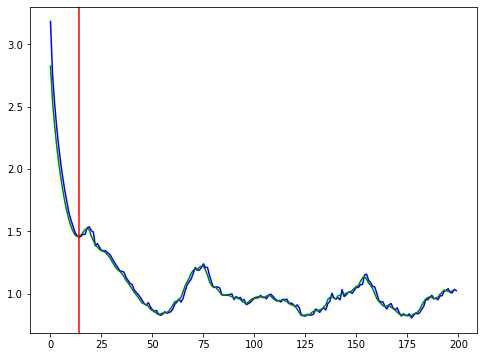

./corrDimTesting/lorenz_z_1000_v1.npy


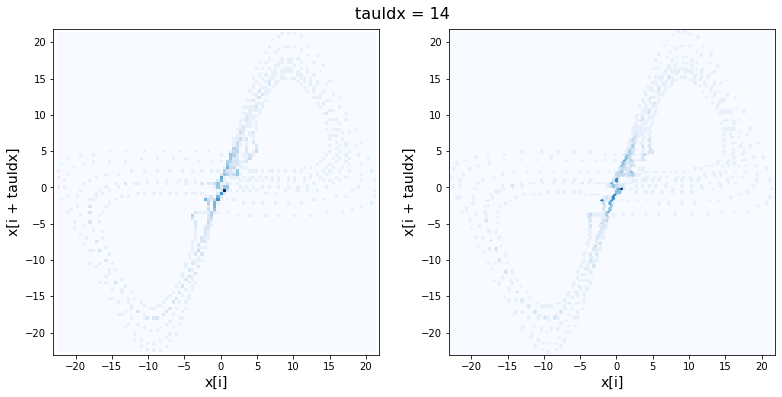

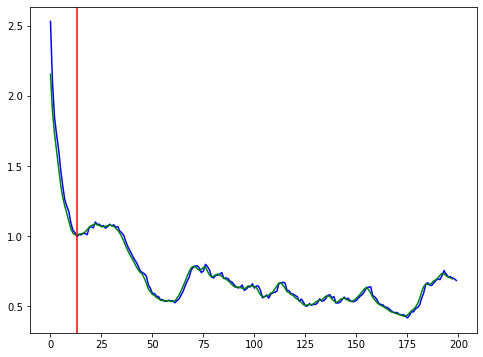

./corrDimTesting/rossler_x_1000_v1.npy


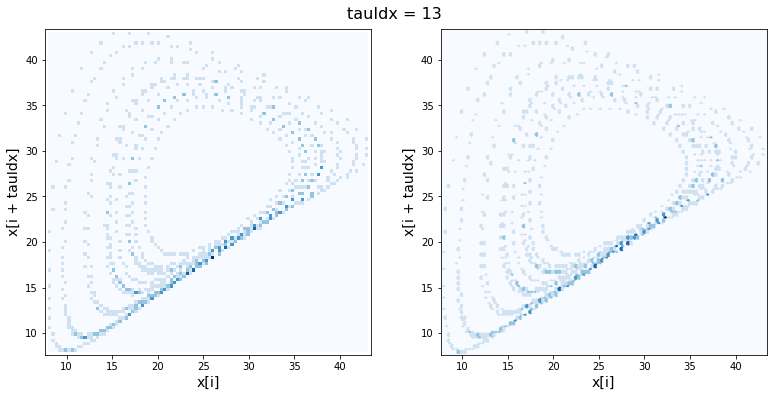

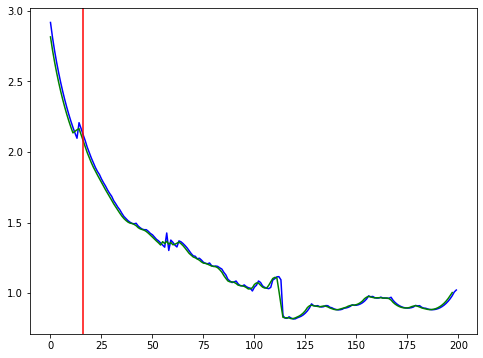

./corrDimTesting/rossler_y_1000_v1.npy


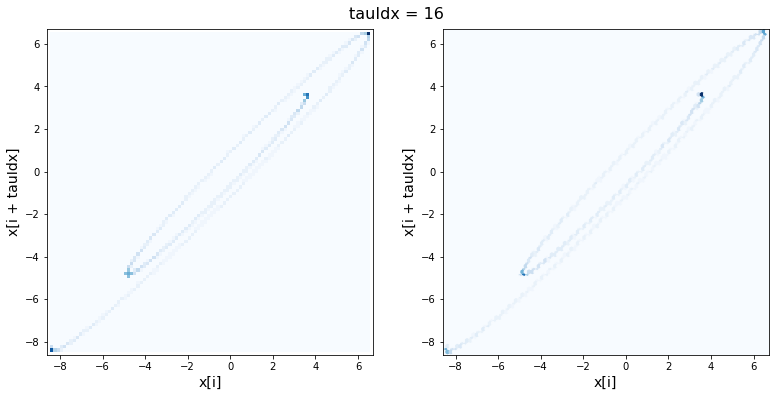

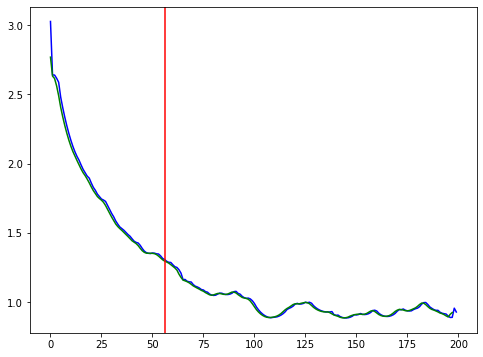

./corrDimTesting/rossler_z_1000_v1.npy


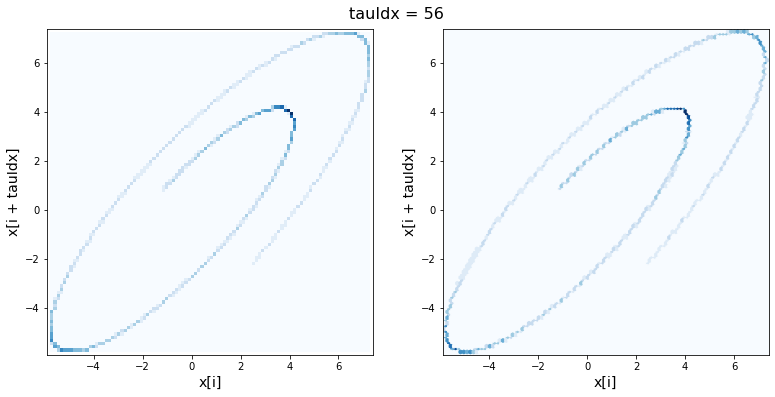

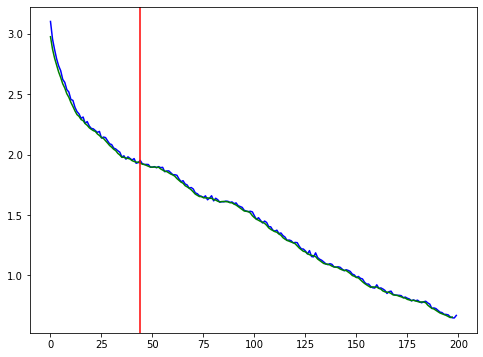

./corrDimTesting/rotated_rossler_x_1000_v1.npy


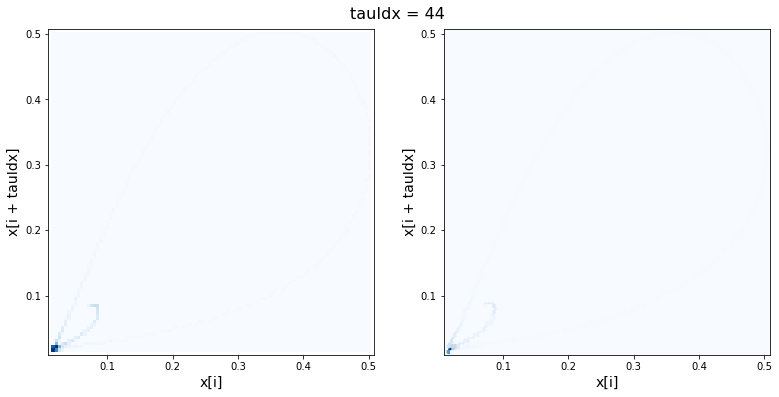

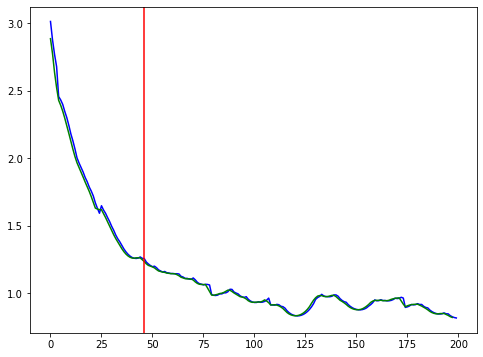

./corrDimTesting/rotated_rossler_y_1000_v1.npy


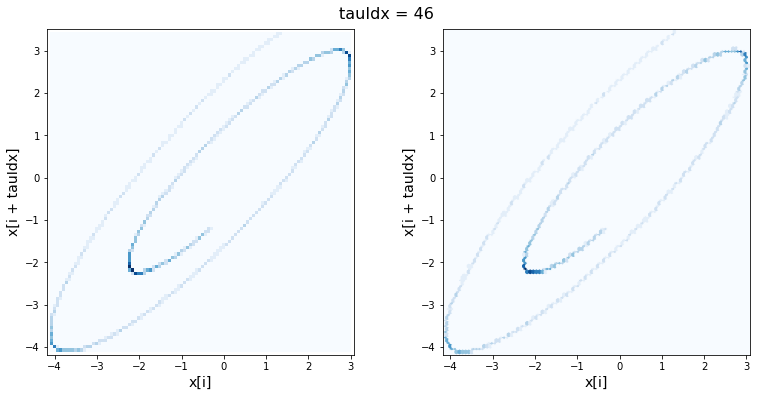

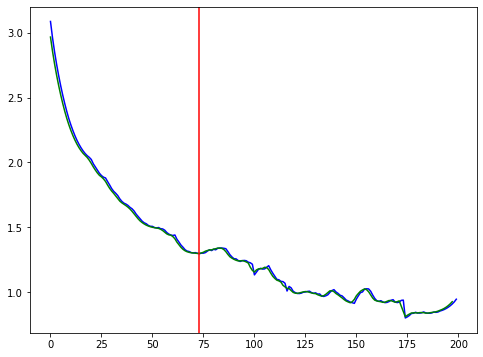

./corrDimTesting/rotated_rossler_z_1000_v1.npy


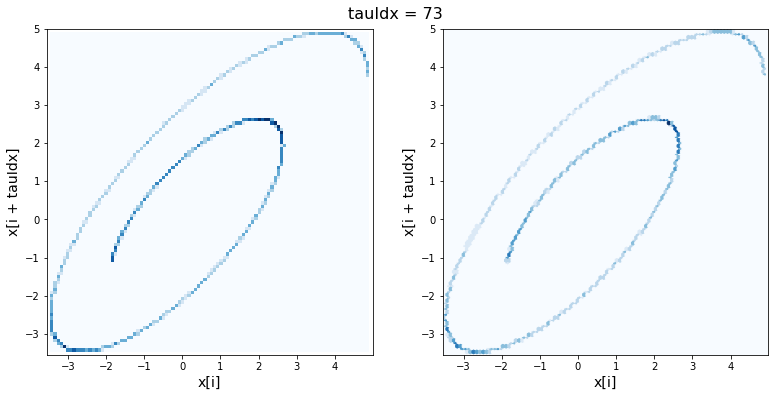

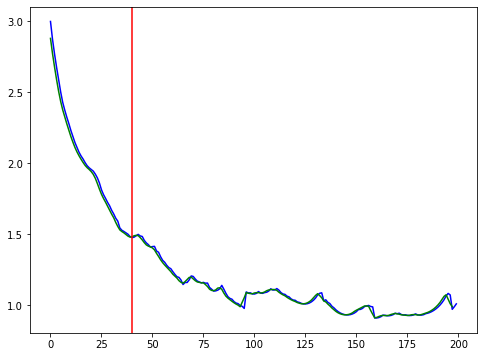

./corrDimTesting/lorenz_x_1000_v2.npy


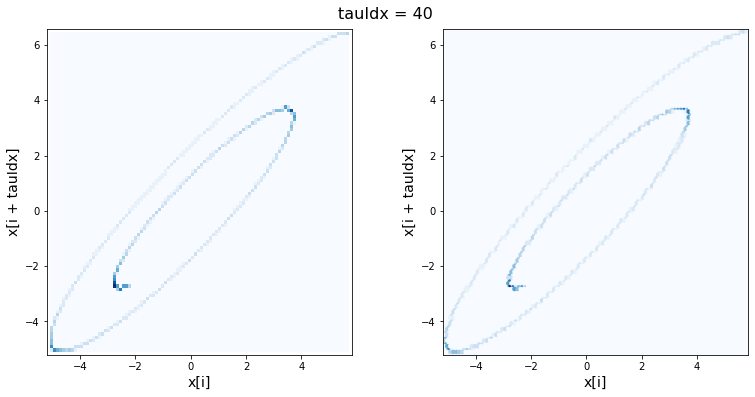

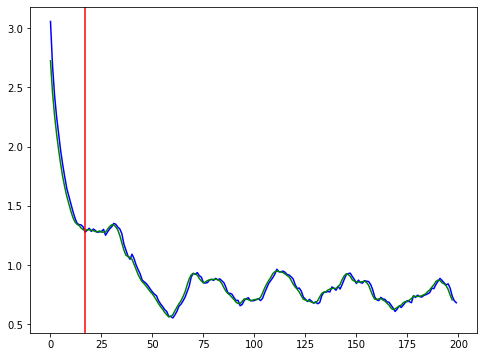

./corrDimTesting/lorenz_y_1000_v2.npy


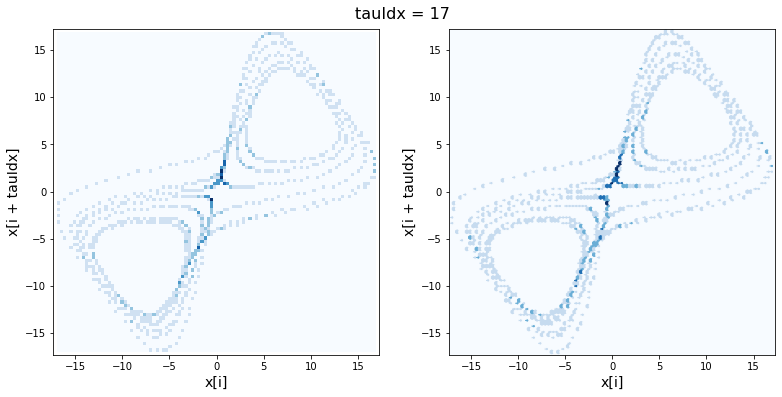

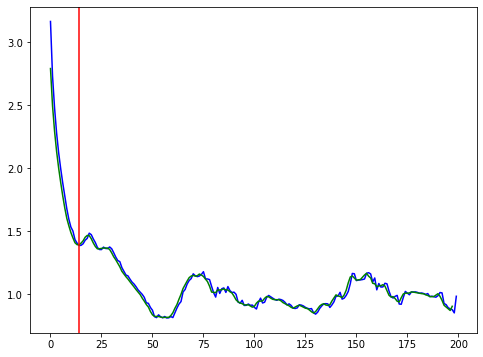

./corrDimTesting/lorenz_z_1000_v2.npy


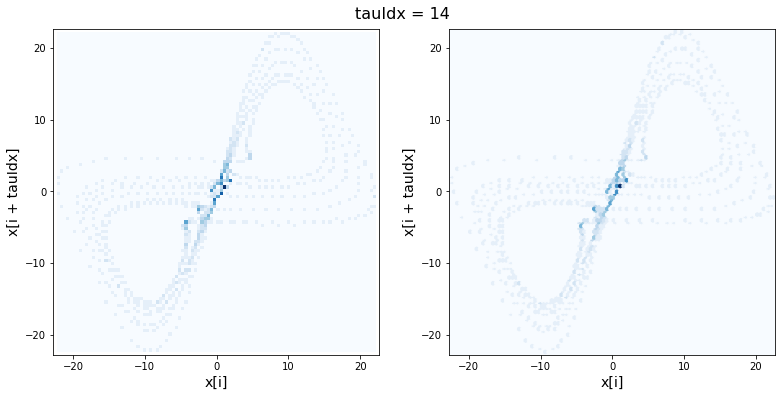

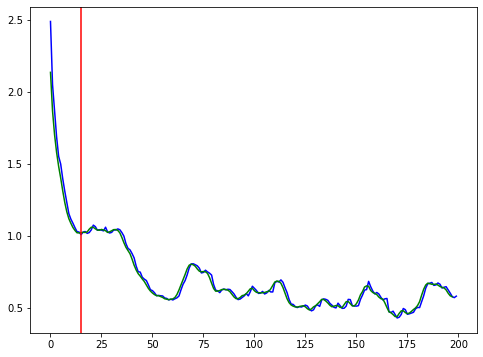

./corrDimTesting/rossler_x_1000_v2.npy


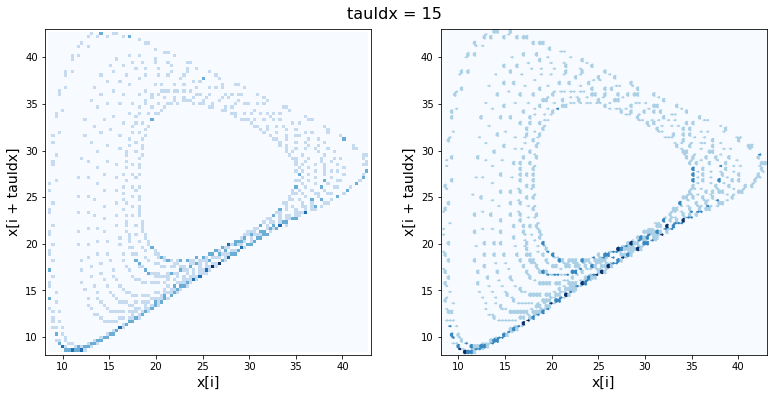

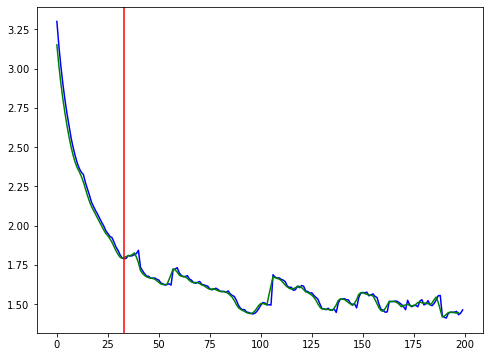

./corrDimTesting/rossler_y_1000_v2.npy


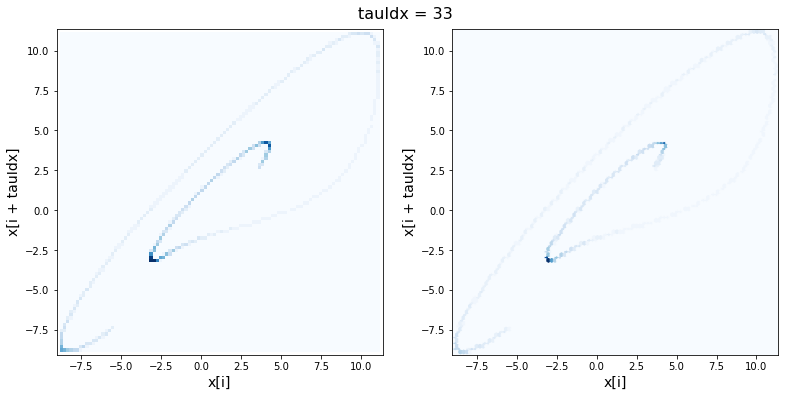

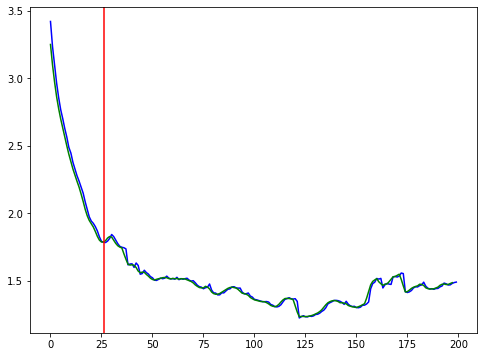

./corrDimTesting/rossler_z_1000_v2.npy


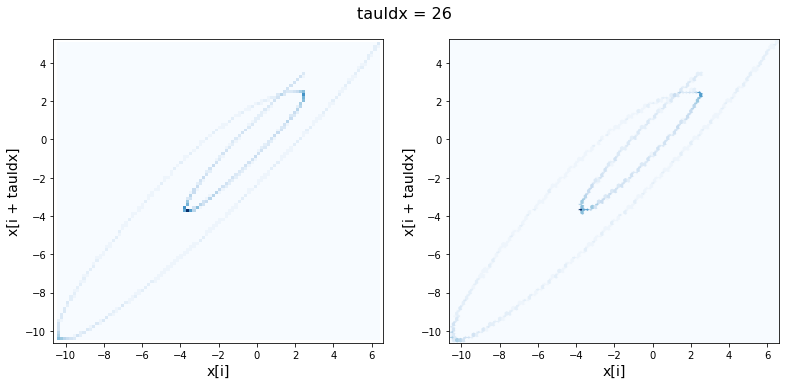

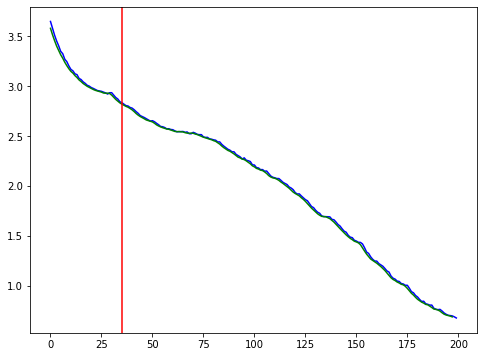

./corrDimTesting/rotated_rossler_x_1000_v2.npy


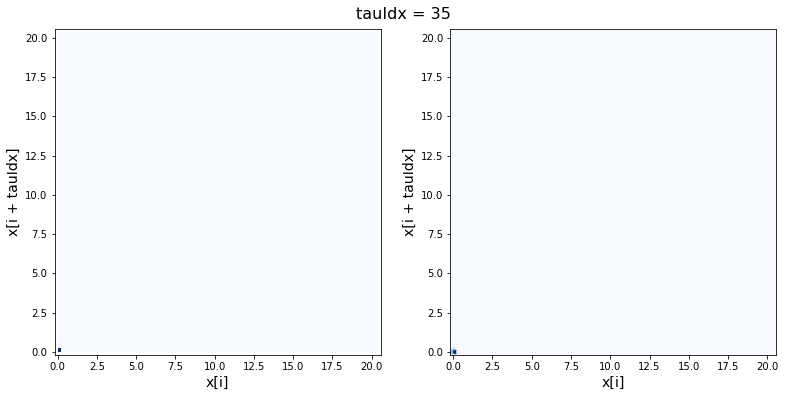

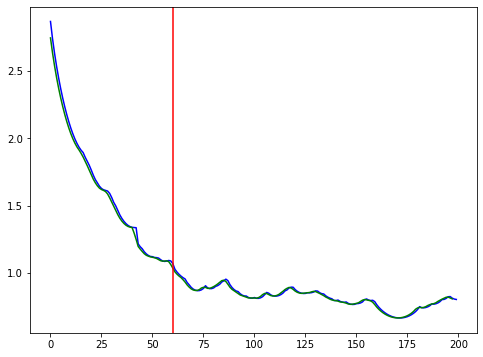

./corrDimTesting/rotated_rossler_y_1000_v2.npy


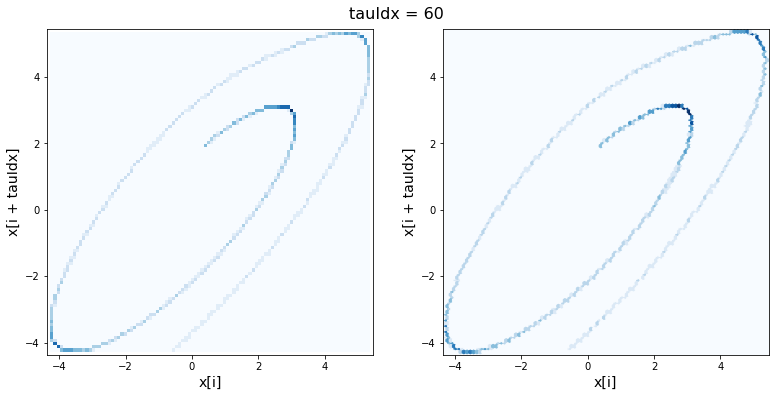

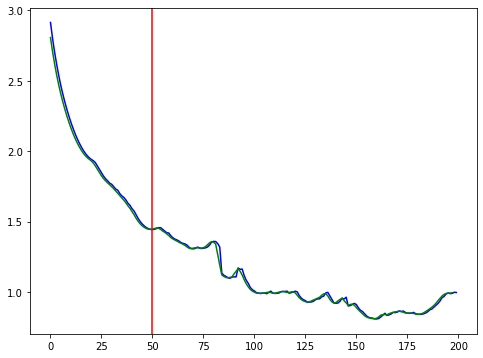

./corrDimTesting/rotated_rossler_z_1000_v2.npy


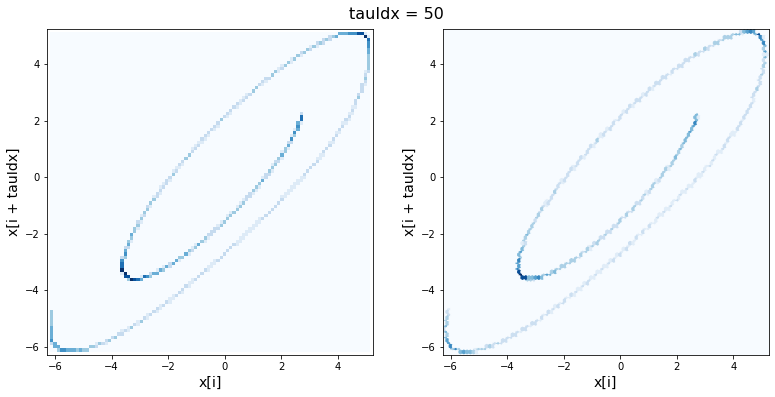

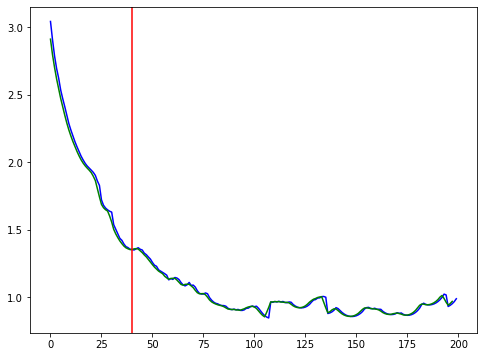

./corrDimTesting/lorenz_x_5000_v0.npy


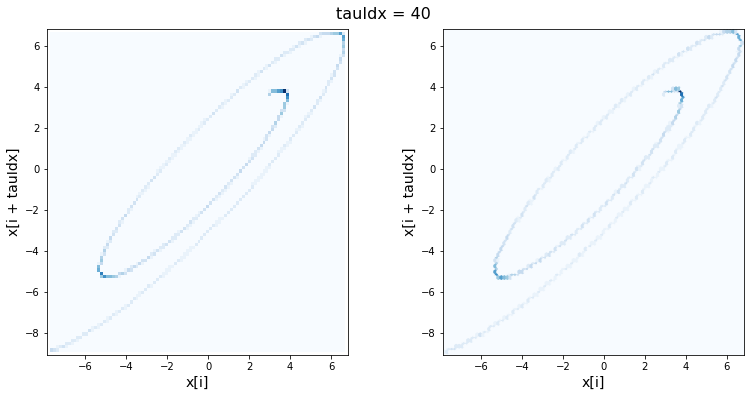

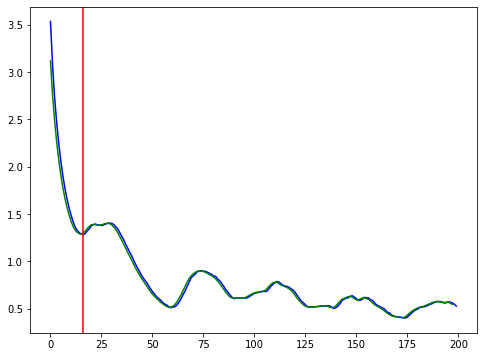

./corrDimTesting/lorenz_y_5000_v0.npy


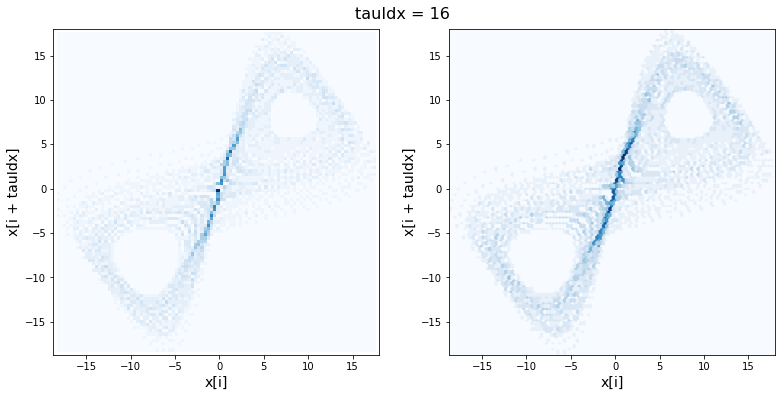

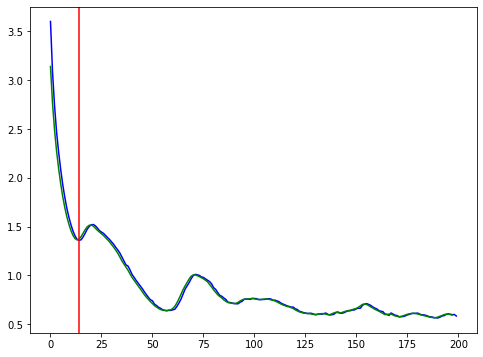

./corrDimTesting/lorenz_z_5000_v0.npy


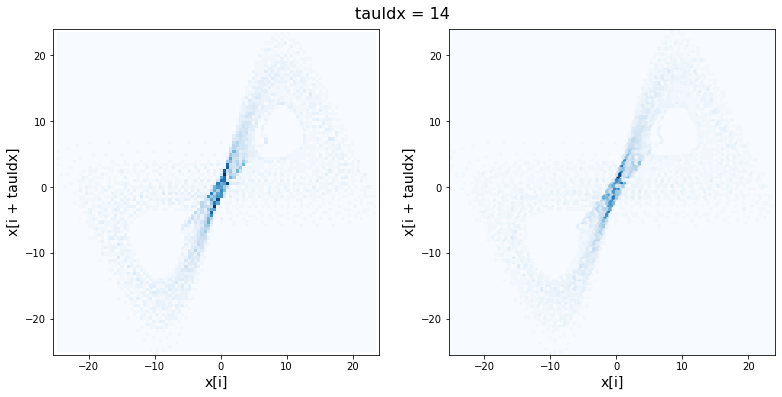

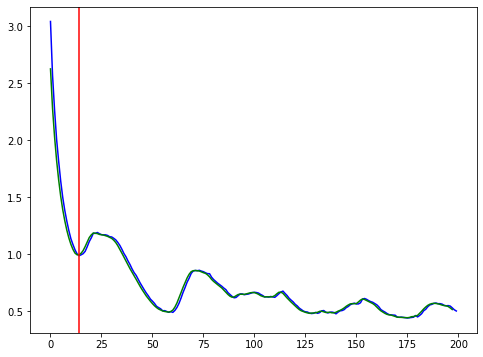

./corrDimTesting/rossler_x_5000_v0.npy


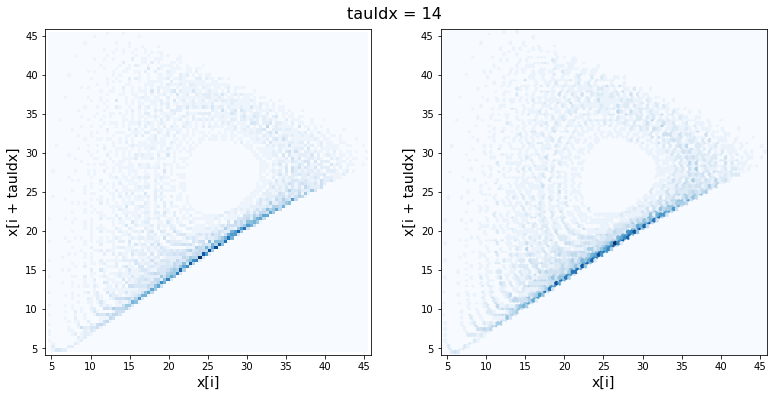

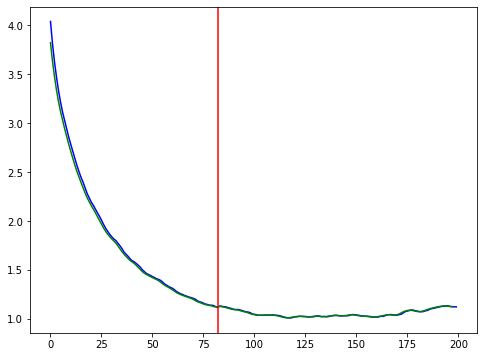

./corrDimTesting/rossler_y_5000_v0.npy


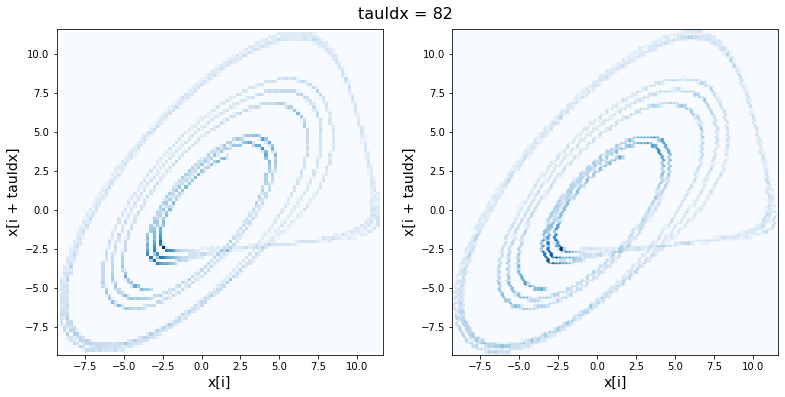

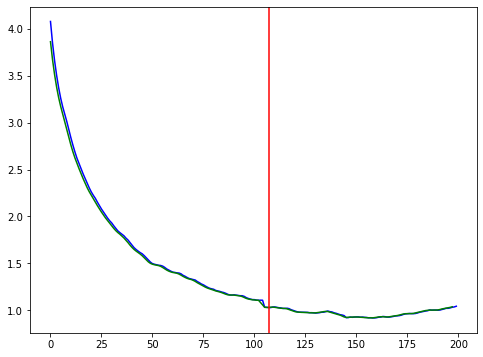

./corrDimTesting/rossler_z_5000_v0.npy


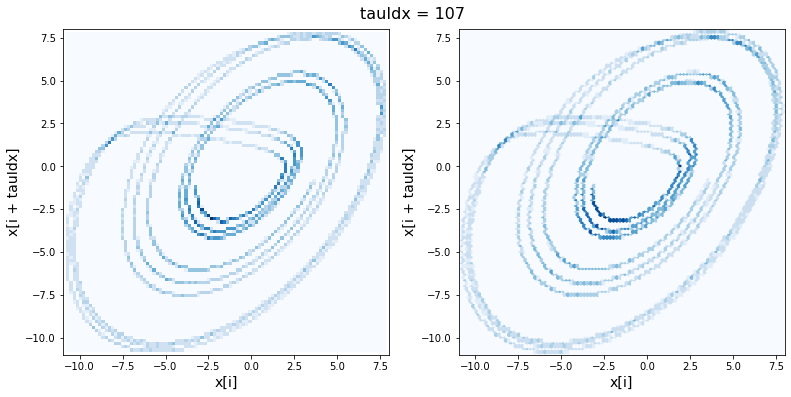

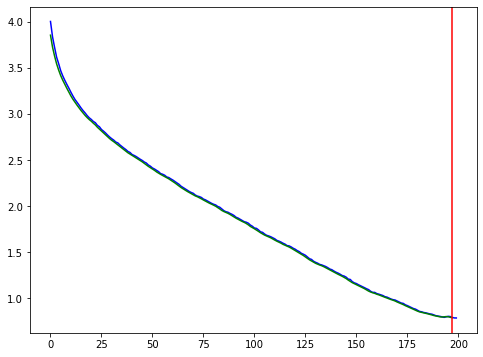

./corrDimTesting/rotated_rossler_x_5000_v0.npy


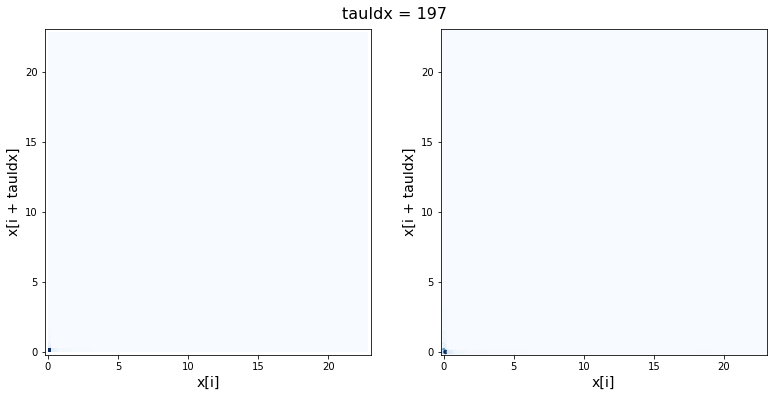

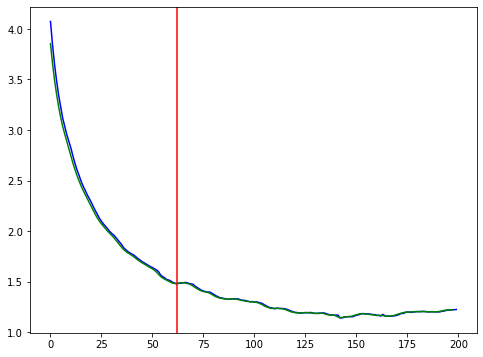

./corrDimTesting/rotated_rossler_y_5000_v0.npy


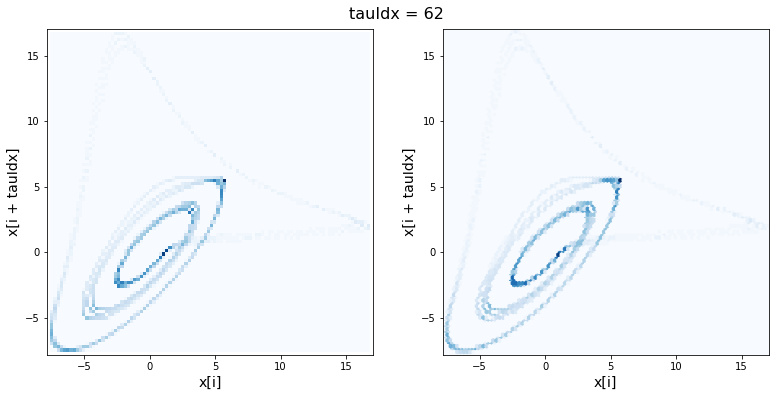

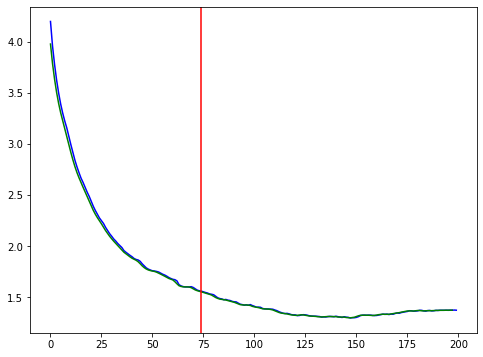

./corrDimTesting/rotated_rossler_z_5000_v0.npy


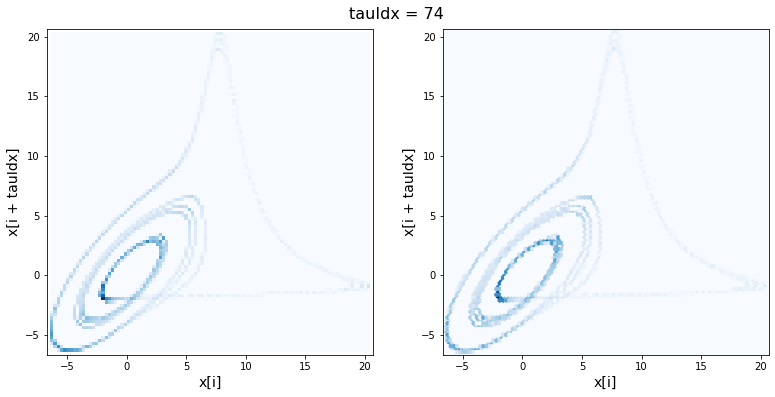

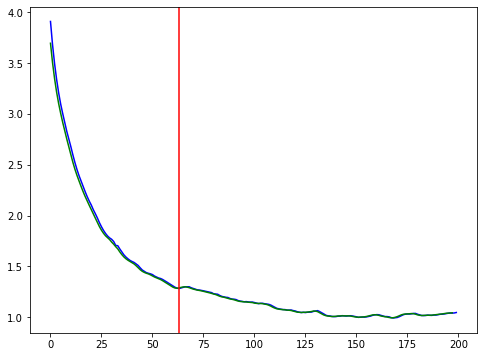

./corrDimTesting/lorenz_x_5000_v1.npy


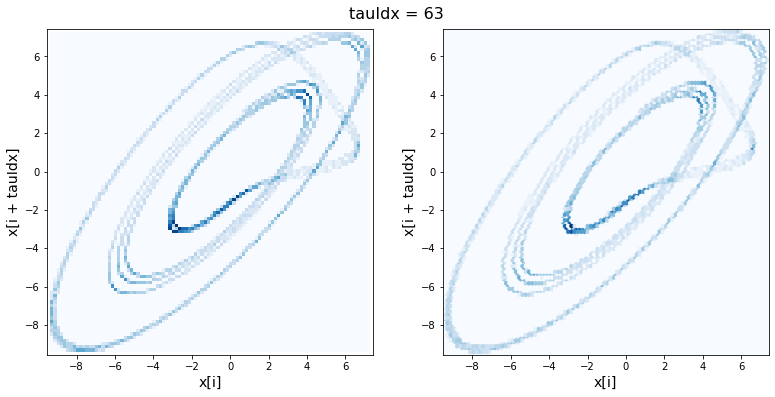

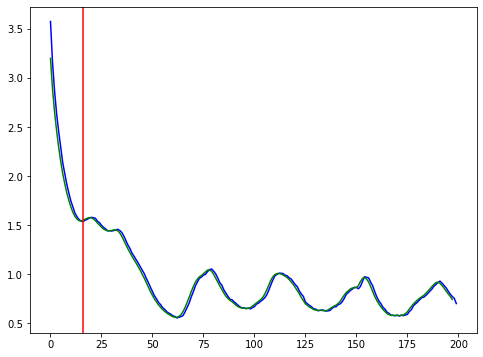

./corrDimTesting/lorenz_y_5000_v1.npy


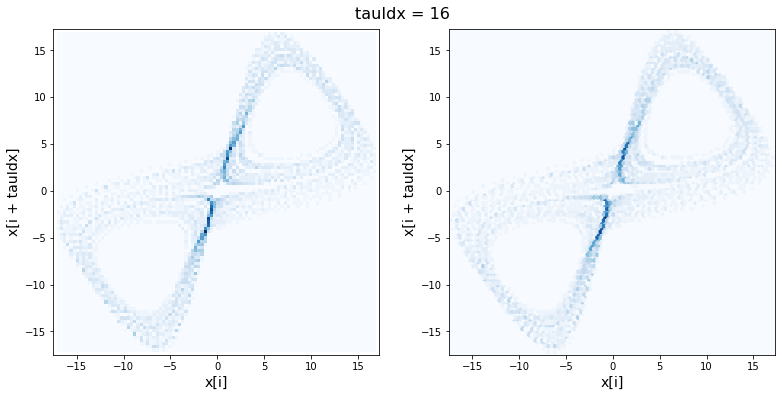

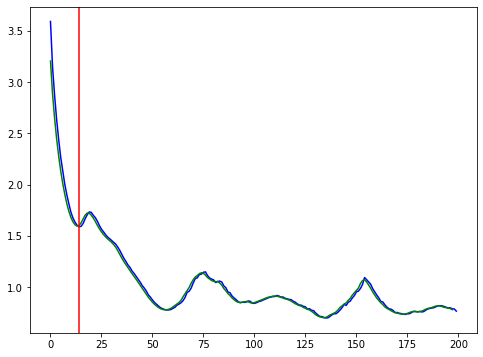

./corrDimTesting/lorenz_z_5000_v1.npy


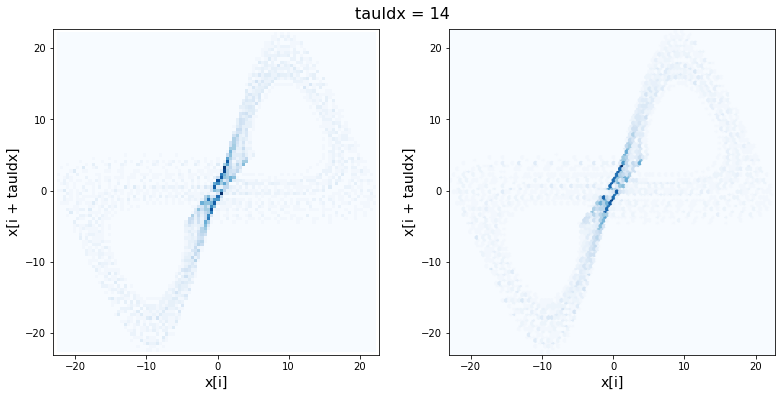

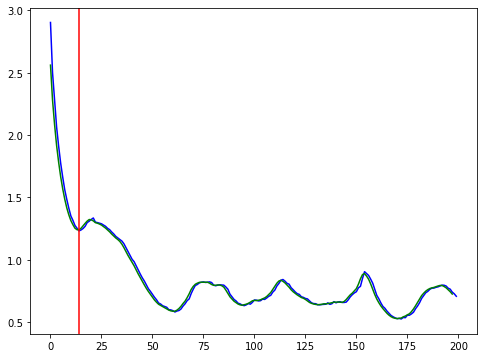

./corrDimTesting/rossler_x_5000_v1.npy


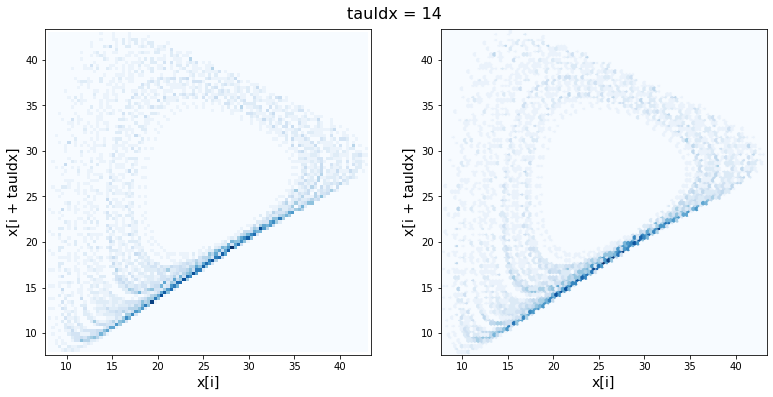

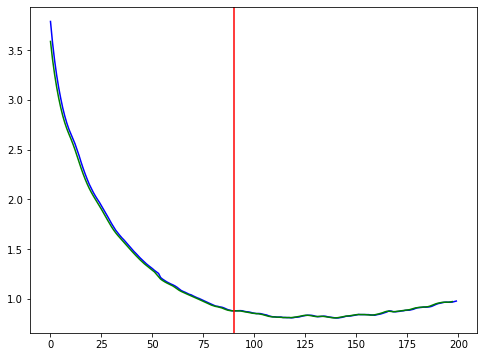

./corrDimTesting/rossler_y_5000_v1.npy


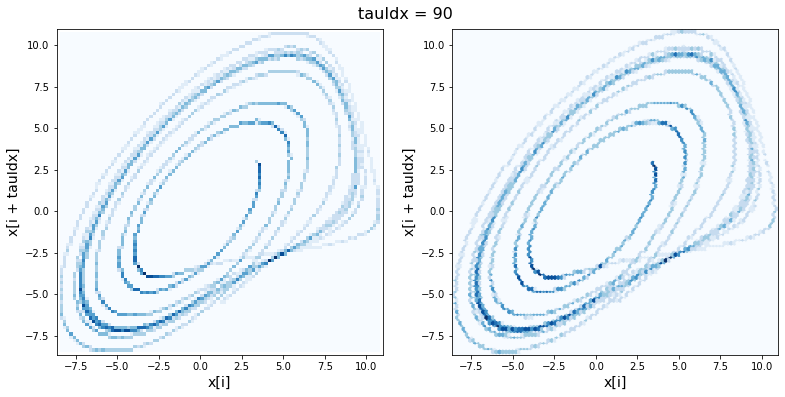

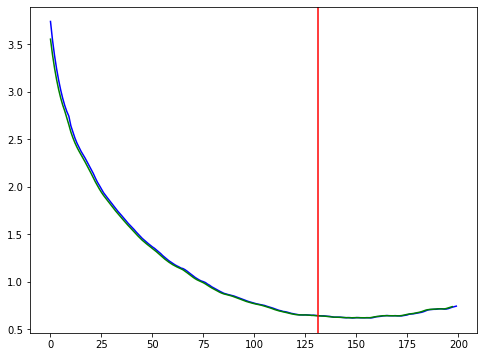

./corrDimTesting/rossler_z_5000_v1.npy


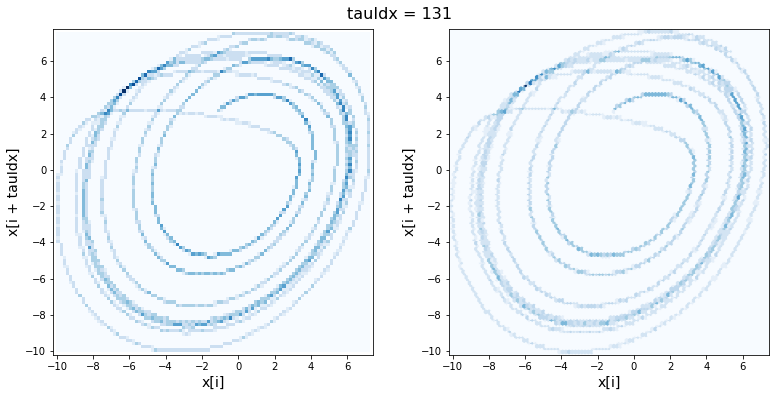

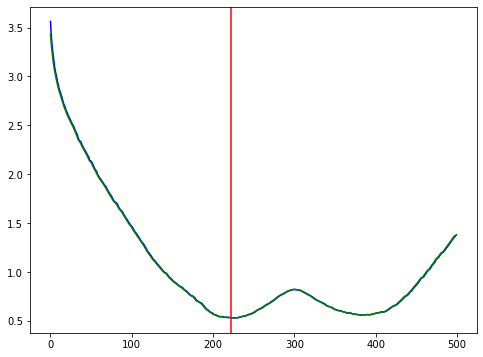

./corrDimTesting/rotated_rossler_x_5000_v1.npy


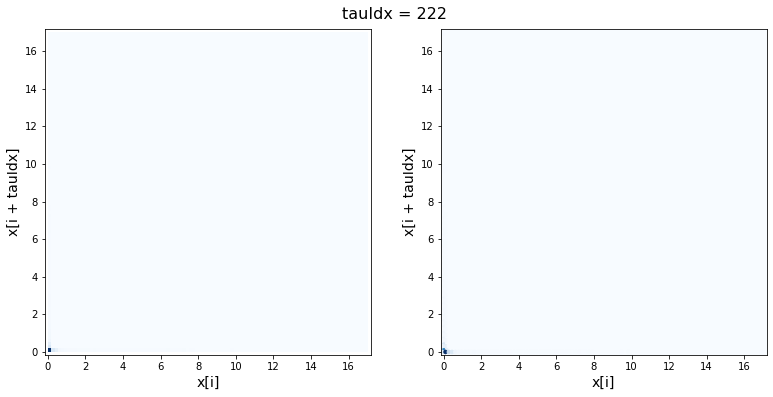

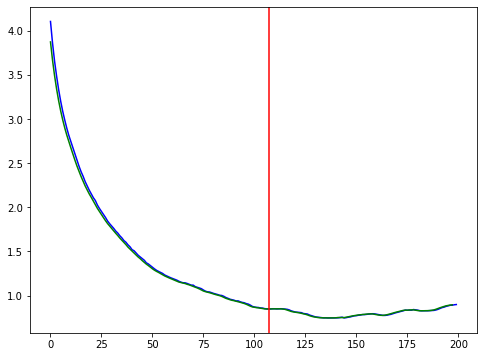

./corrDimTesting/rotated_rossler_y_5000_v1.npy


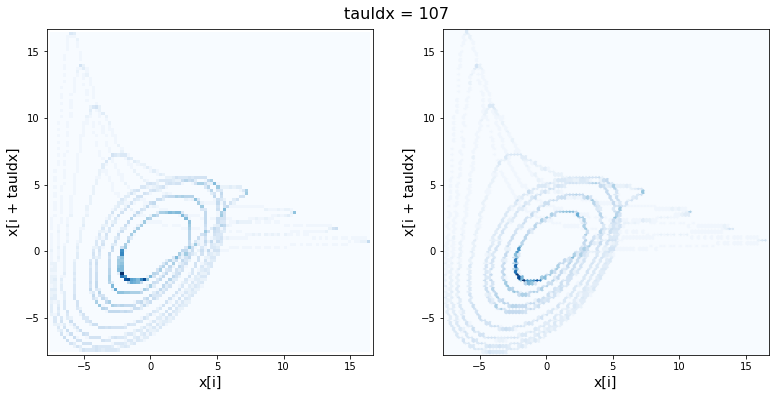

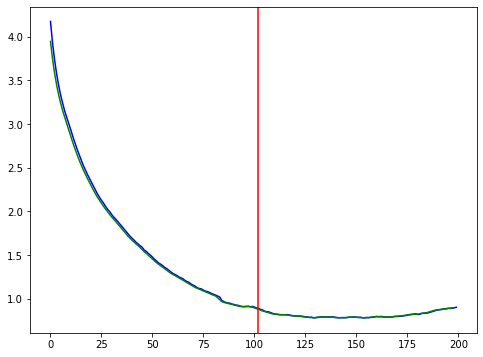

./corrDimTesting/rotated_rossler_z_5000_v1.npy


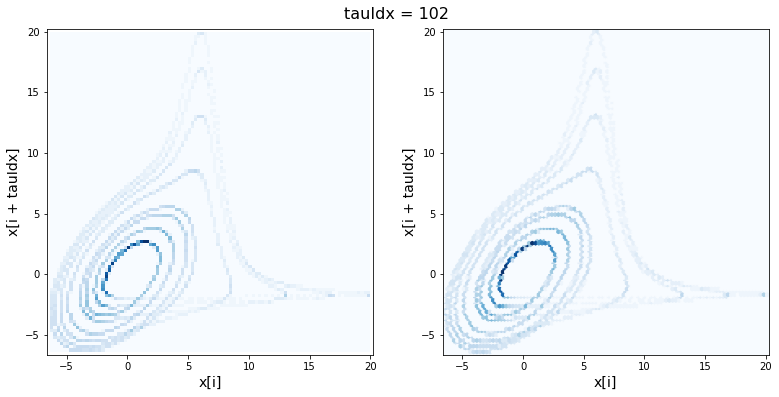

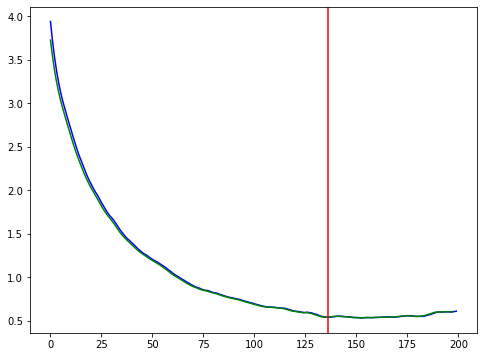

./corrDimTesting/lorenz_x_5000_v2.npy


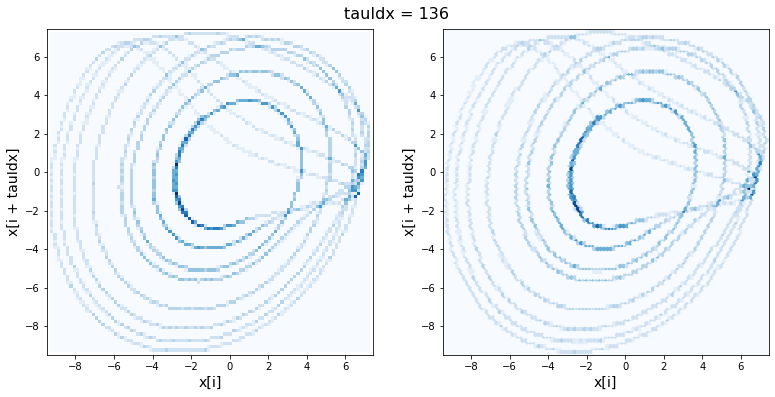

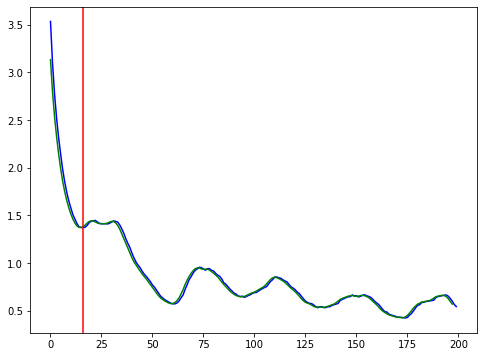

./corrDimTesting/lorenz_y_5000_v2.npy


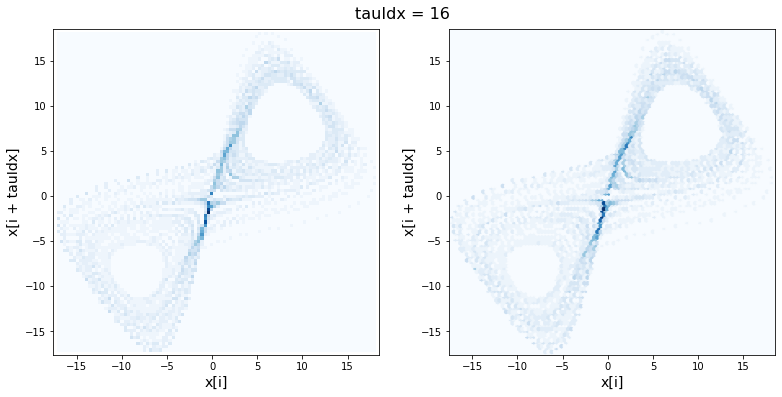

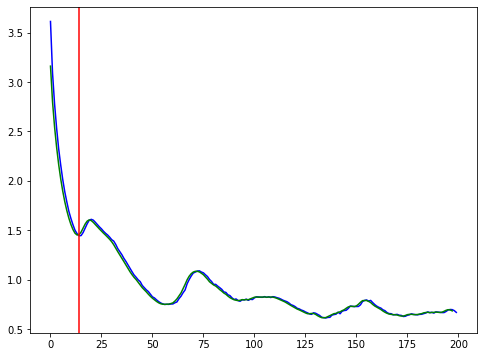

./corrDimTesting/lorenz_z_5000_v2.npy


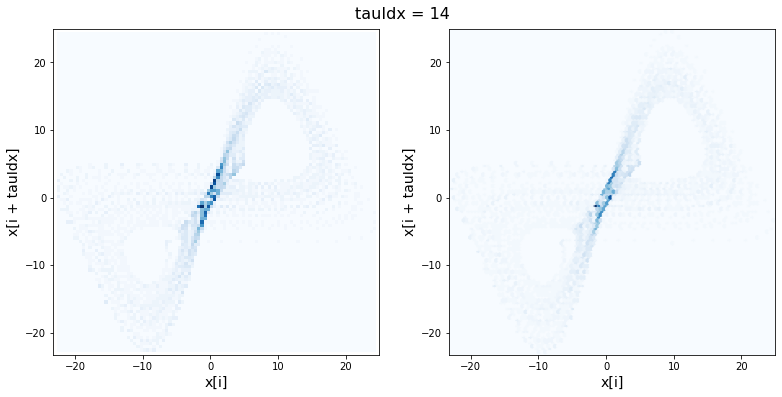

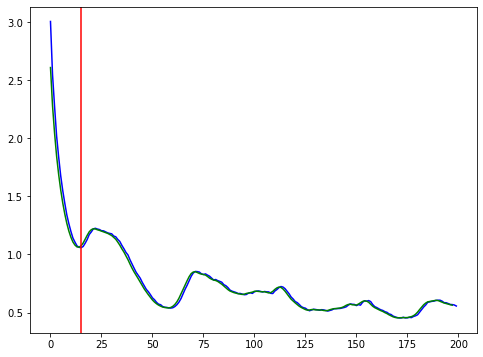

./corrDimTesting/rossler_x_5000_v2.npy


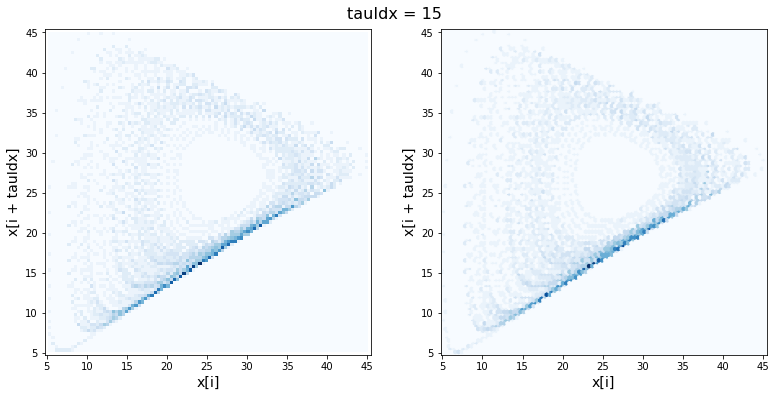

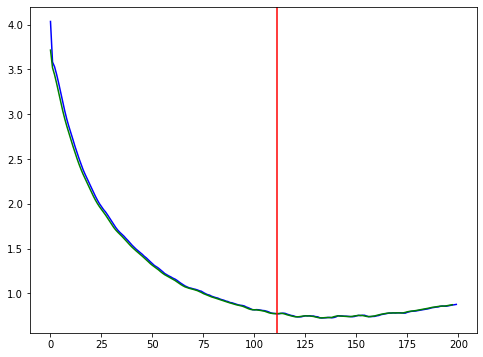

./corrDimTesting/rossler_y_5000_v2.npy


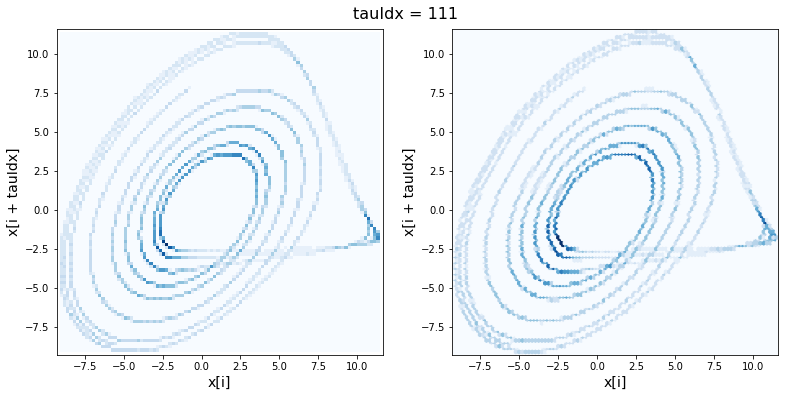

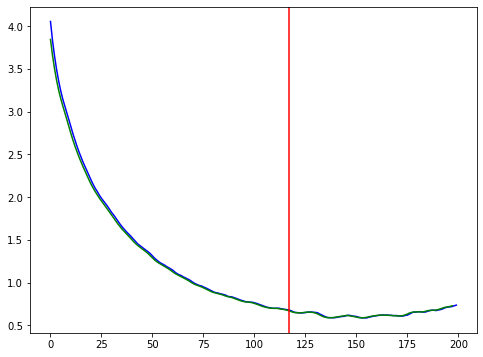

./corrDimTesting/rossler_z_5000_v2.npy


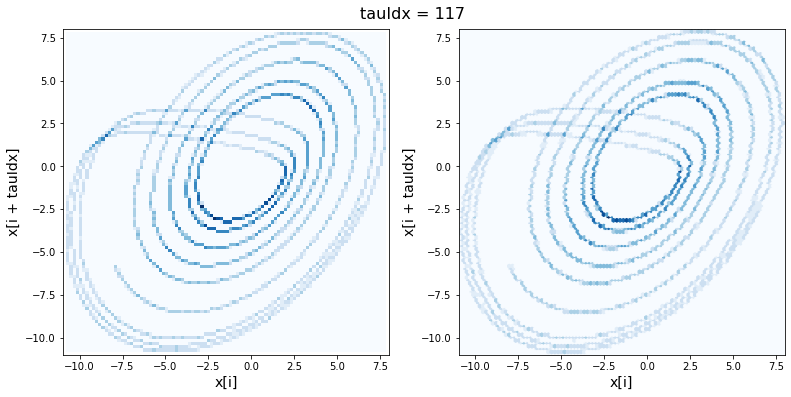

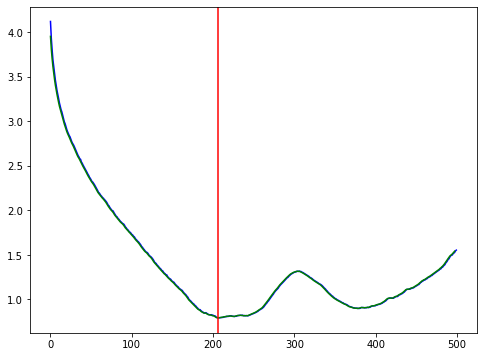

./corrDimTesting/rotated_rossler_x_5000_v2.npy


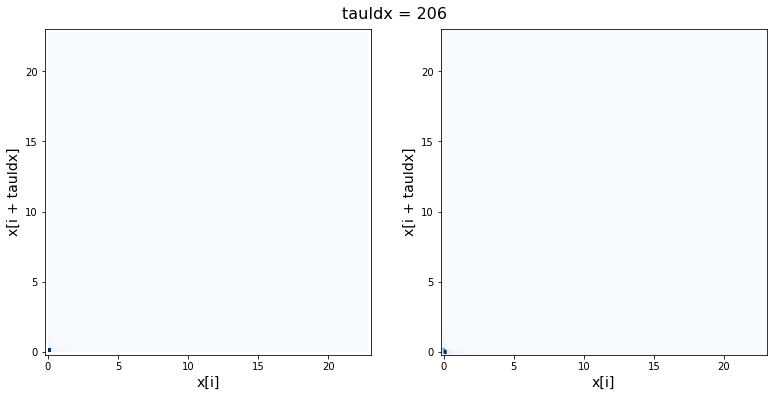

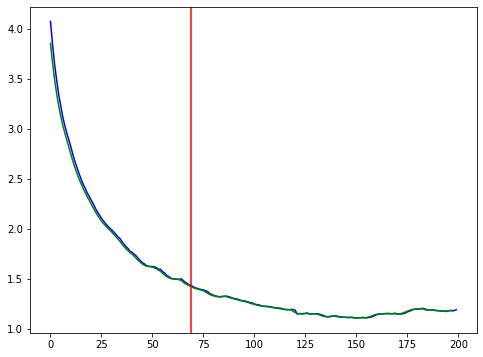

./corrDimTesting/rotated_rossler_y_5000_v2.npy


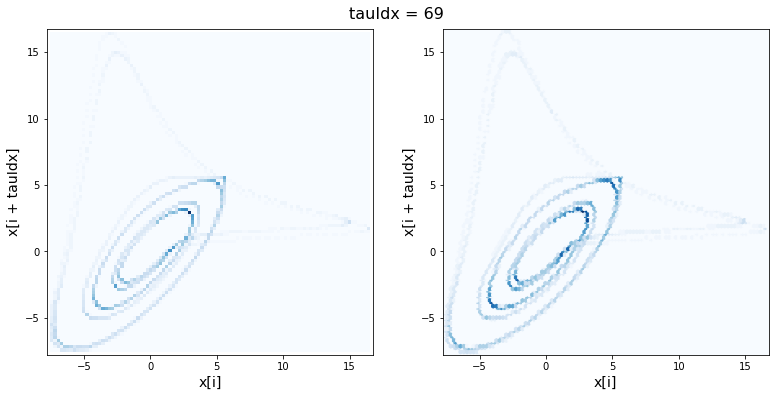

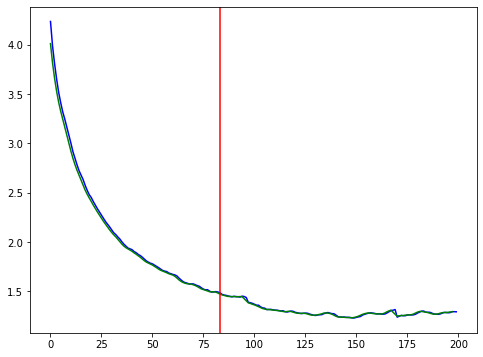

./corrDimTesting/rotated_rossler_z_5000_v2.npy


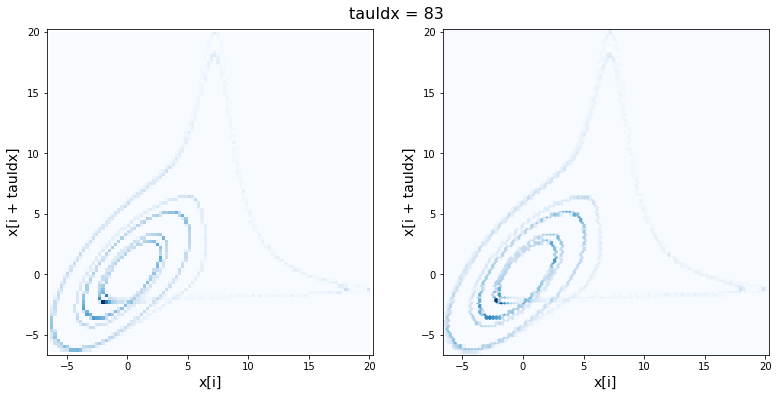

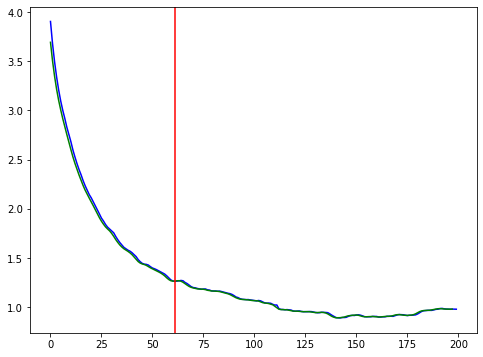

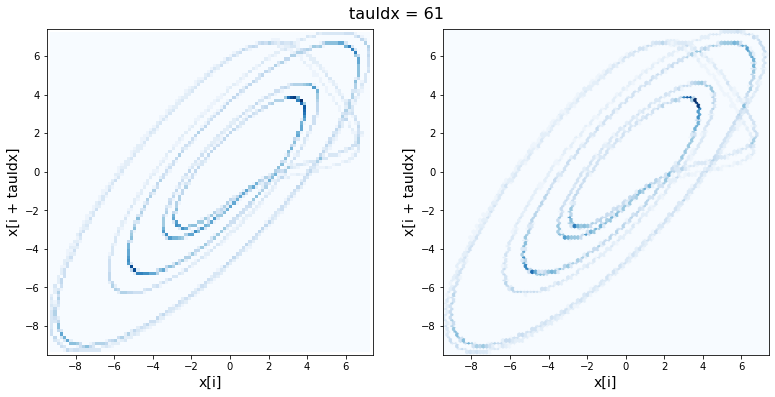

In [39]:
for ts in timeSeriesArrs:
    print(ts)
    timeSeries = np.load(ts)
    
    fileName = ts.split("/")[-1].split(".")[0]
    #print(fileName)
    
    if "rotated" in fileName:
        name = fileName.split("_")[0] + "_" + fileName.split("_")[1] + "_" + fileName.split("_")[2]
    else:
        name = fileName.split("_")[0] + "_" + fileName.split("_")[1]
    
    length = int(fileName.split("_")[-2])
    version = int(fileName.split("_")[-1][-1])
    
    # appropriate regardless of whether time series is from Lorenz, Rossler, or rotated Rossler
    mArr = np.array((3,4))
    
    try:
        mutInfo, bestTau = sp.FS86(timeSeries = timeSeries, trialDelayIndices = np.arange(0,200), plot=True)
    except IndexError:
        mutInfo, bestTau = sp.FS86(timeSeries = timeSeries, trialDelayIndices = np.arange(0,500), plot=True)
    
    for m in mArr:
        if os.path.exists("./corrDimTesting/{0}_tau={1}_m={2}_C0.npy".format(fileName,bestTau,m)):
            pass
        else:
            #print("./corrDimTesting/{0}_tau={1}_m={2}_C0.npy".format(fileName,bestTau,m))
            C0_, C1_, C2_, nArr_ = sp.Cq(rArr=rArr, timeSeries=timeSeries, tau = bestTau, m = m)
            np.save("./corrDimTesting/{0}_tau={1}_m={2}_C0.npy".format(fileName,bestTau,m),C0_)
            np.save("./corrDimTesting/{0}_tau={1}_m={2}_C1.npy".format(fileName,bestTau,m),C1_)
            np.save("./corrDimTesting/{0}_tau={1}_m={2}_C2.npy".format(fileName,bestTau,m),C2_)
            np.save("./corrDimTesting/{0}_tau={1}_m={2}_nArr.npy".format(fileName,bestTau,m),nArr_)
        

## Plot results of multiple runs

In [41]:
C0_1000_arrs = ! ls ./corrDimTesting/*1000_*C0.npy*
C0_5000_arrs = ! ls ./corrDimTesting/*5000_*C0.npy*
C0_arrs = list(C0_1000_arrs) + list(C0_5000_arrs)
print(C0_arrs)
print(len(C0_arrs))

['./corrDimTesting/lorenz_x_1000_v0_tau=15_m=3_C0.npy', './corrDimTesting/lorenz_x_1000_v0_tau=15_m=4_C0.npy', './corrDimTesting/lorenz_x_1000_v0_tau=16_m=3_C0.npy', './corrDimTesting/lorenz_x_1000_v0_tau=16_m=4_C0.npy', './corrDimTesting/lorenz_x_1000_v0_tau=60_m=3_C0.npy', './corrDimTesting/lorenz_x_1000_v0_tau=60_m=4_C0.npy', './corrDimTesting/lorenz_x_1000_v1_tau=27_m=3_C0.npy', './corrDimTesting/lorenz_x_1000_v1_tau=27_m=4_C0.npy', './corrDimTesting/lorenz_x_1000_v2_tau=17_m=3_C0.npy', './corrDimTesting/lorenz_x_1000_v2_tau=17_m=4_C0.npy', './corrDimTesting/lorenz_y_1000_v0_tau=16_m=3_C0.npy', './corrDimTesting/lorenz_y_1000_v0_tau=16_m=4_C0.npy', './corrDimTesting/lorenz_y_1000_v1_tau=14_m=3_C0.npy', './corrDimTesting/lorenz_y_1000_v1_tau=14_m=4_C0.npy', './corrDimTesting/lorenz_y_1000_v2_tau=14_m=3_C0.npy', './corrDimTesting/lorenz_y_1000_v2_tau=14_m=4_C0.npy', './corrDimTesting/lorenz_z_1000_v0_tau=14_m=3_C0.npy', './corrDimTesting/lorenz_z_1000_v0_tau=14_m=4_C0.npy', './corrDi

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


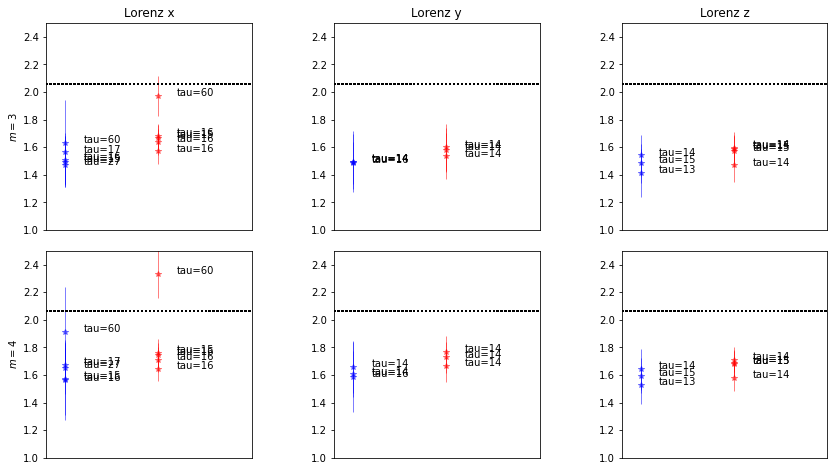

In [88]:
lorenz_truth = 2.06 # e.g. https://www.sciencedirect.com/science/article/pii/037596018390052X?via%3Dihub
rossler_truth = 2.01 # https://sprott.physics.wisc.edu/pubs/paper255.pdf

fig, axes = plt.subplots(2,3,figsize=(14,8))#plt.subplots(4,3,figsize=(8,8))

for f in C0_arrs:
    #print(f)
    C0_ = np.load(f)
    
    fileName = f.split("/")[-1].split(".")[0]
    #print(fileName)
    
    C1_ = np.load("./corrDimTesting/" + fileName[:-2] + "C1.npy")
    C2_ = np.load("./corrDimTesting/" + fileName[:-2] + "C2.npy")
    nArr_ = np.load("./corrDimTesting/" + fileName[:-2] + "nArr.npy")
    
    if "rotated" in fileName:
        name = fileName.split("_")[0] + "_" + fileName.split("_")[1] + "_" + fileName.split("_")[2]
    else:
        name = fileName.split("_")[0] + "_" + fileName.split("_")[1]
    
    length = int(fileName.split("_")[-5])
    version = int(fileName.split("_")[-4][-1])
    tau = int(fileName.split("_")[-3].split("=")[-1])
    m = int(fileName.split("_")[-2].split("=")[-1])
    
    params_C0, params_unc_C0 = sp.fitLinearRegime(rArr, nArr_, C0_)
    params_C1, params_unc_C1 = sp.fitLinearRegime(rArr, nArr_, C1_)
    params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr_, C2_)
    
     
    if "lorenz_x" in fileName:# and "rotated" not in fileName:
        if m==3:
            if length==1000:
                axes[0,0].errorbar(1, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='b', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[0,0].annotate("tau={0}".format(tau), (1.2, params_C2[0]))
            elif length==5000:
                axes[0,0].errorbar(2, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='r', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[0,0].annotate("tau={0}".format(tau), (2.2, params_C2[0]))
        elif m==4:
            if length==1000:
                axes[1,0].errorbar(1, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='b', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[1,0].annotate("tau={0}".format(tau), (1.2, params_C2[0]))
            elif length==5000:
                axes[1,0].errorbar(2, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='r', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[1,0].annotate("tau={0}".format(tau), (2.2, params_C2[0]))
    if "lorenz_y" in fileName:# and "rotated" not in fileName:
        if m==3:
            if length==1000:
                axes[0,1].errorbar(1, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='b', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[0,1].annotate("tau={0}".format(tau), (1.2, params_C2[0]))
            elif length==5000:
                axes[0,1].errorbar(2, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='r', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[0,1].annotate("tau={0}".format(tau), (2.2, params_C2[0]))
        elif m==4:
            if length==1000:
                axes[1,1].errorbar(1, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='b', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[1,1].annotate("tau={0}".format(tau), (1.2, params_C2[0]))
            elif length==5000:
                axes[1,1].errorbar(2, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='r', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[1,1].annotate("tau={0}".format(tau), (2.2, params_C2[0]))
    if "lorenz_z" in fileName:# and "rotated" not in fileName:
        if m==3:
            if length==1000:
                axes[0,2].errorbar(1, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='b', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[0,2].annotate("tau={0}".format(tau), (1.2, params_C2[0]))
            elif length==5000:
                axes[0,2].errorbar(2, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='r', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[0,2].annotate("tau={0}".format(tau), (2.2, params_C2[0]))
        elif m==4:
            if length==1000:
                axes[1,2].errorbar(1, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='b', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[1,2].annotate("tau={0}".format(tau), (1.2, params_C2[0]))
            elif length==5000:
                axes[1,2].errorbar(2, params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color='r', elinewidth=1,label='tau={0}'.format(tau),alpha=0.5)
                axes[1,2].annotate("tau={0}".format(tau), (2.2, params_C2[0]))
    axes[0,0].set_ylabel(r"$m=3$")
    axes[1,0].set_ylabel(r"$m=4$")
    
    axes[0,0].set_title("Lorenz x")
    axes[0,1].set_title("Lorenz y")
    axes[0,2].set_title("Lorenz z")
    
    for ax in np.ravel(axes):
        ax.axhline(y = lorenz_truth,color='k',linestyle=":",lw=1.5)
        ax.set_xticks([])
        ax.set_ylim(1.,2.5)
        ax.set_xlim(0.8,3.)
        #ax.legend(fontsize=8,loc='best', frameon=False)

plt.subplots_adjust(hspace=0.1,wspace=0.4)
#plt.show()
plt.savefig("./plots/gp1983implementation/lorenz_recoveredPowerLawSlope_severalTrials.pdf")